In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

In [3]:
import display
import dataloader
from dataloader import ThermalData
import clustering
import anomaly_detection

In [4]:
import module_extraction
from module_extraction import Filters, Modules

In [5]:
thermal_npdat_path = "../ModuleExtraction/hokuto/thermal"
input_img_path = '../ModuleExtraction/hokuto/thermal/DJI_0123_R.JPG'

画像データの取得

In [6]:
thermal_img_files = dataloader.get_img_files(dir_path="./images_hokuto/modules",gray=False)
thermal_img_files_gray = dataloader.get_img_files(dir_path="./images_hokuto/modules",gray=True)

In [7]:
type(thermal_img_files), len(thermal_img_files)

(dict, 158)

各モジュールの位置情報を取得

In [8]:
filters = Filters(thermal_npdat_path)
img_org = cv2.imread(input_img_path, 0)
img_filtered = filters.apply_all_filters(img_org)

In [9]:
modules = Modules(img_filtered)
img_con = modules.get_img_contours(img_org, index=False)
img_con_index = modules.get_img_contours(img_org, index=True)

In [10]:
img_mask = cv2.bitwise_and(img_org, img_con)
img_mask_index = modules.add_index(img_mask)

/Users/tnozawa/afterFIT/work/rule_based_anomaly_detection/module_extraction.py:57: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


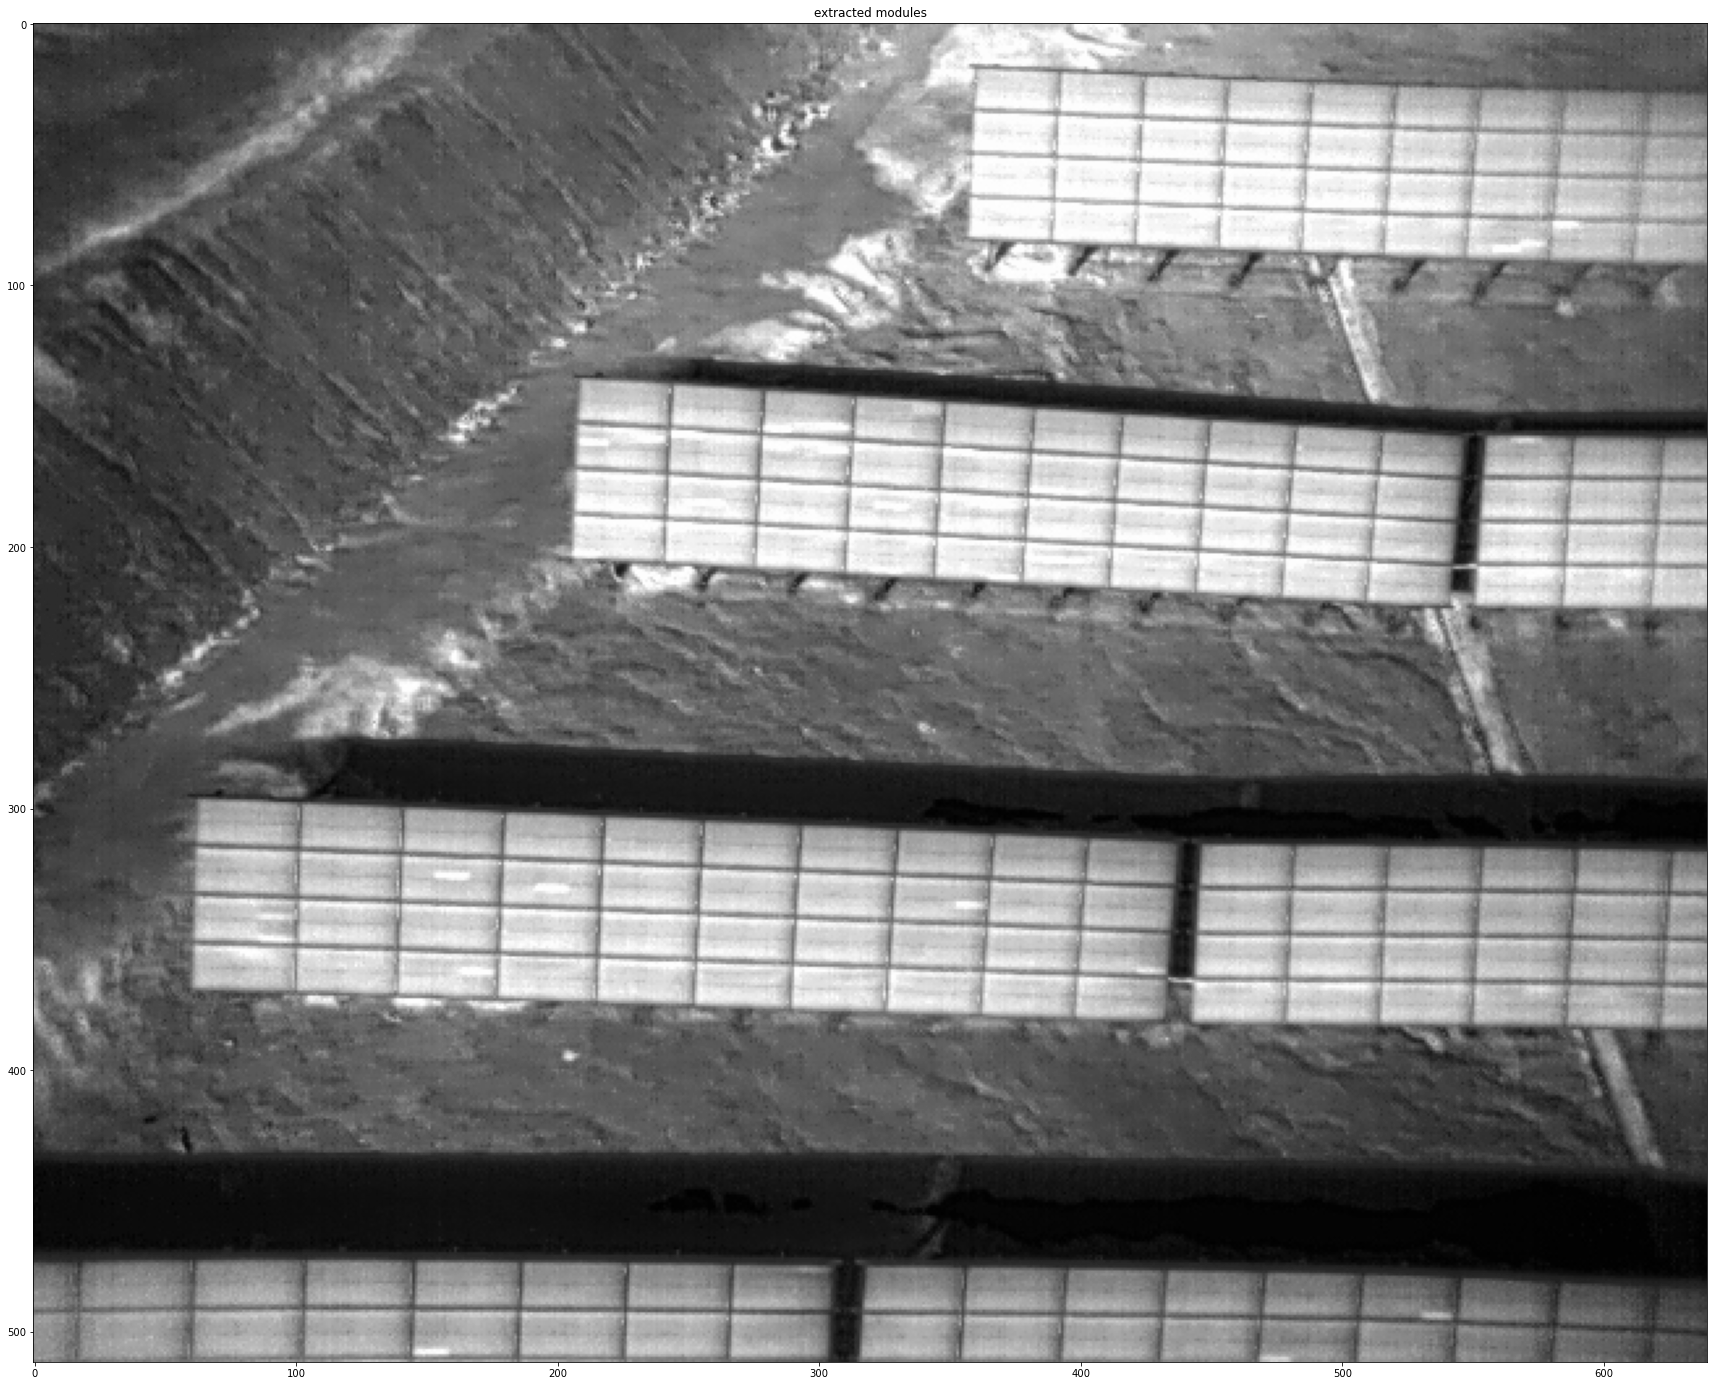

In [11]:
module_extraction.show_img({"extracted modules":img_org},cmap="gray",figsize=(30,30))

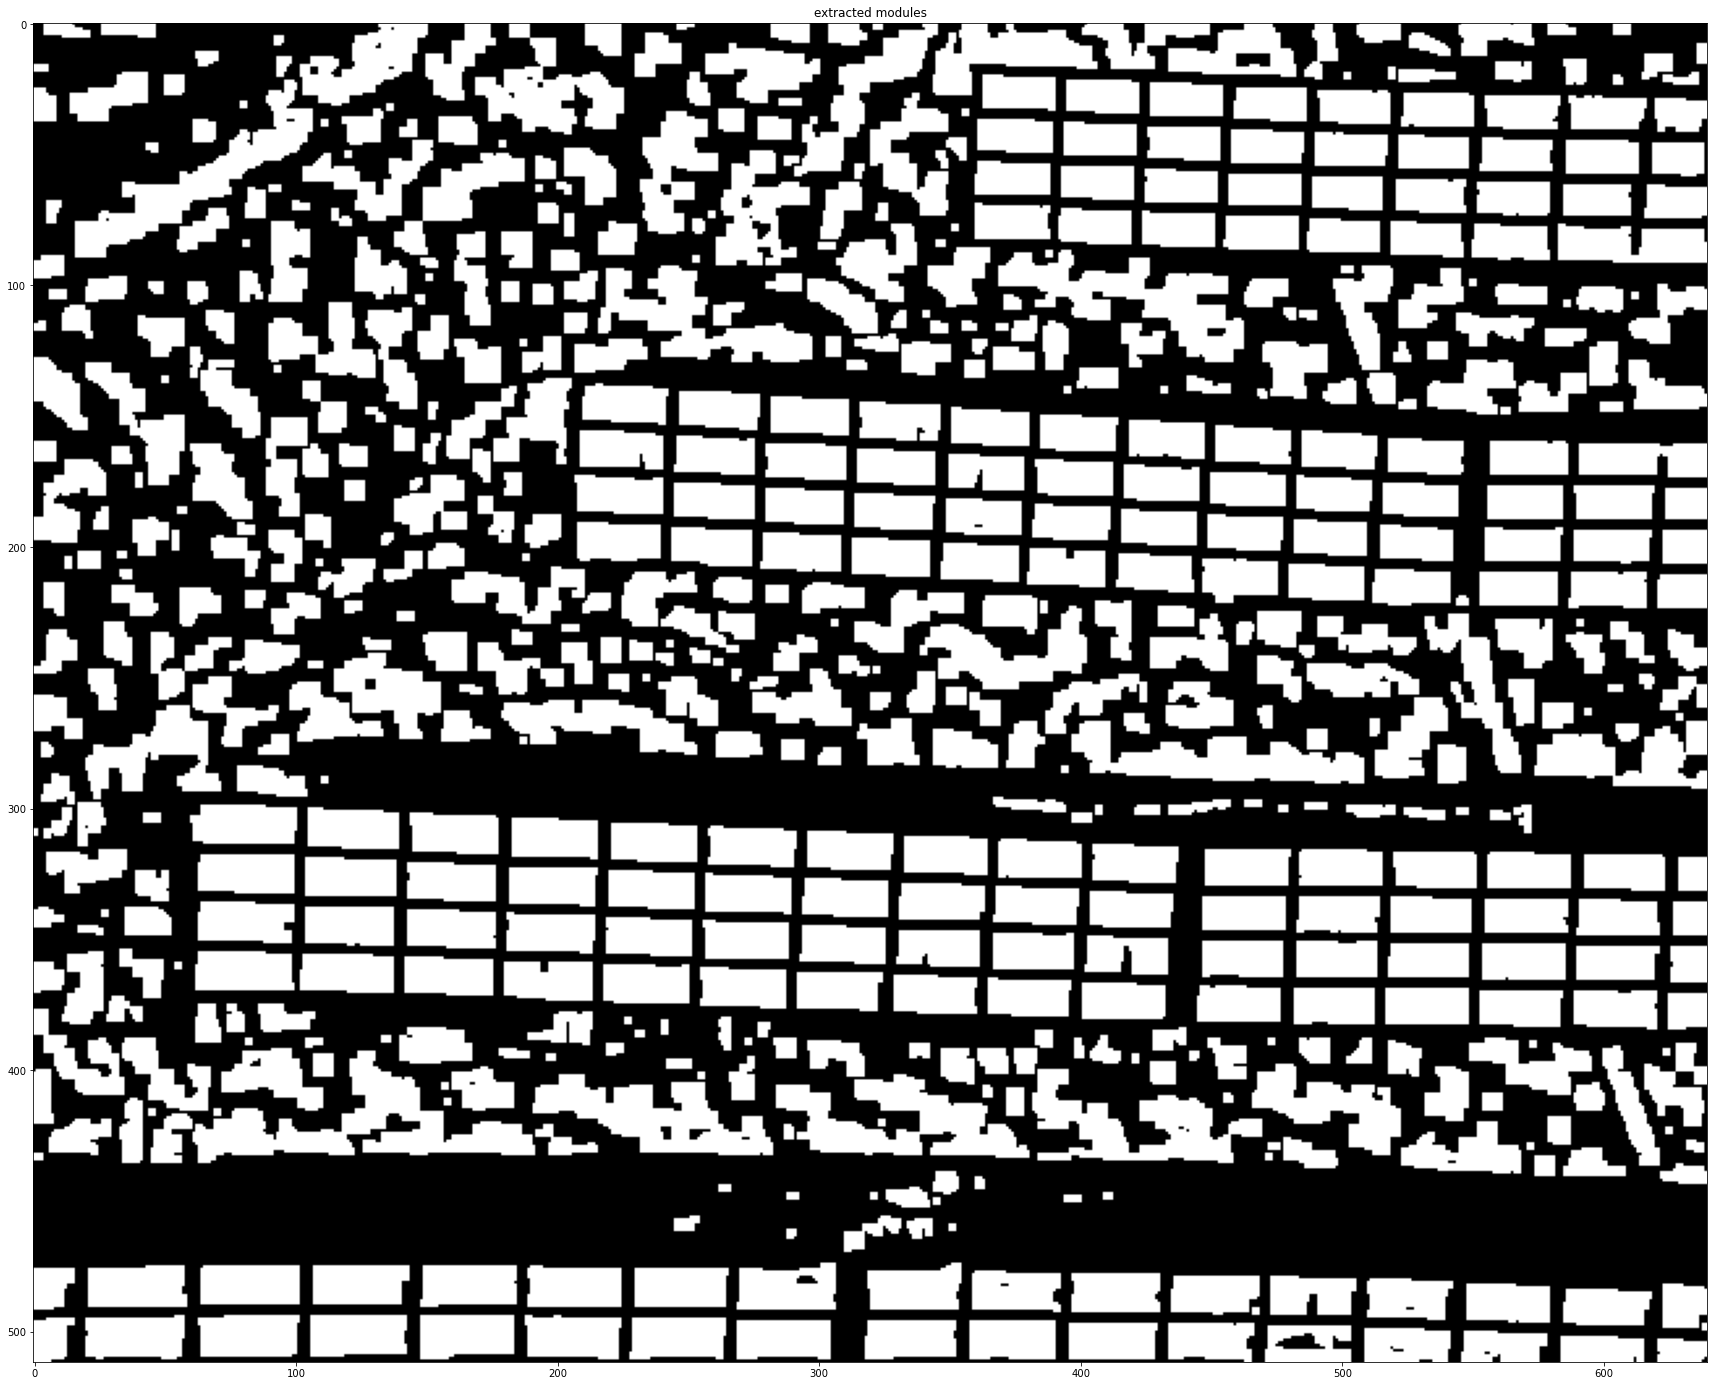

In [12]:
module_extraction.show_img({"extracted modules":img_filtered},cmap="gray",figsize=(30,30))

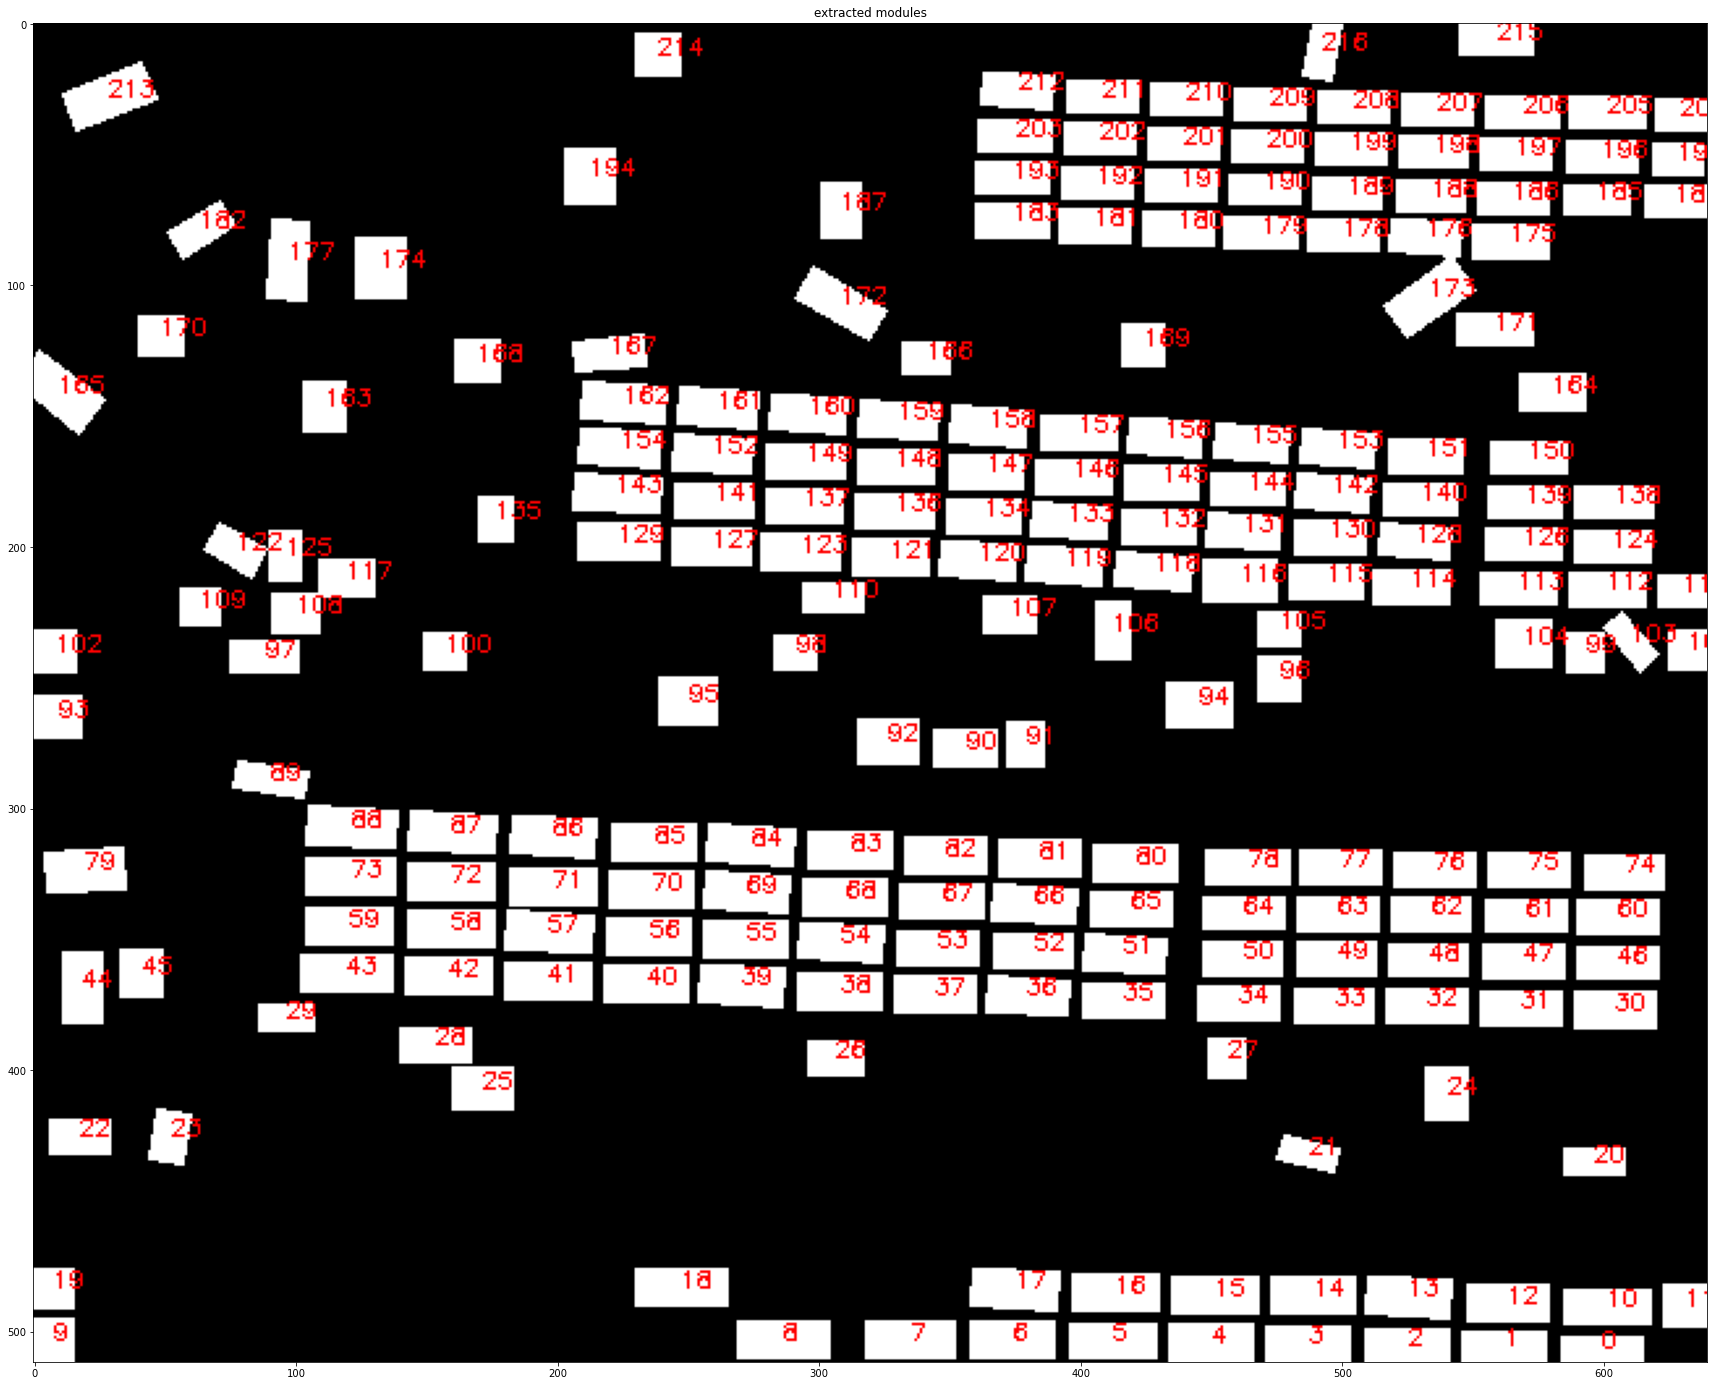

In [13]:
module_extraction.show_img({"extracted modules":img_con_index},cmap="gray",figsize=(30,30))

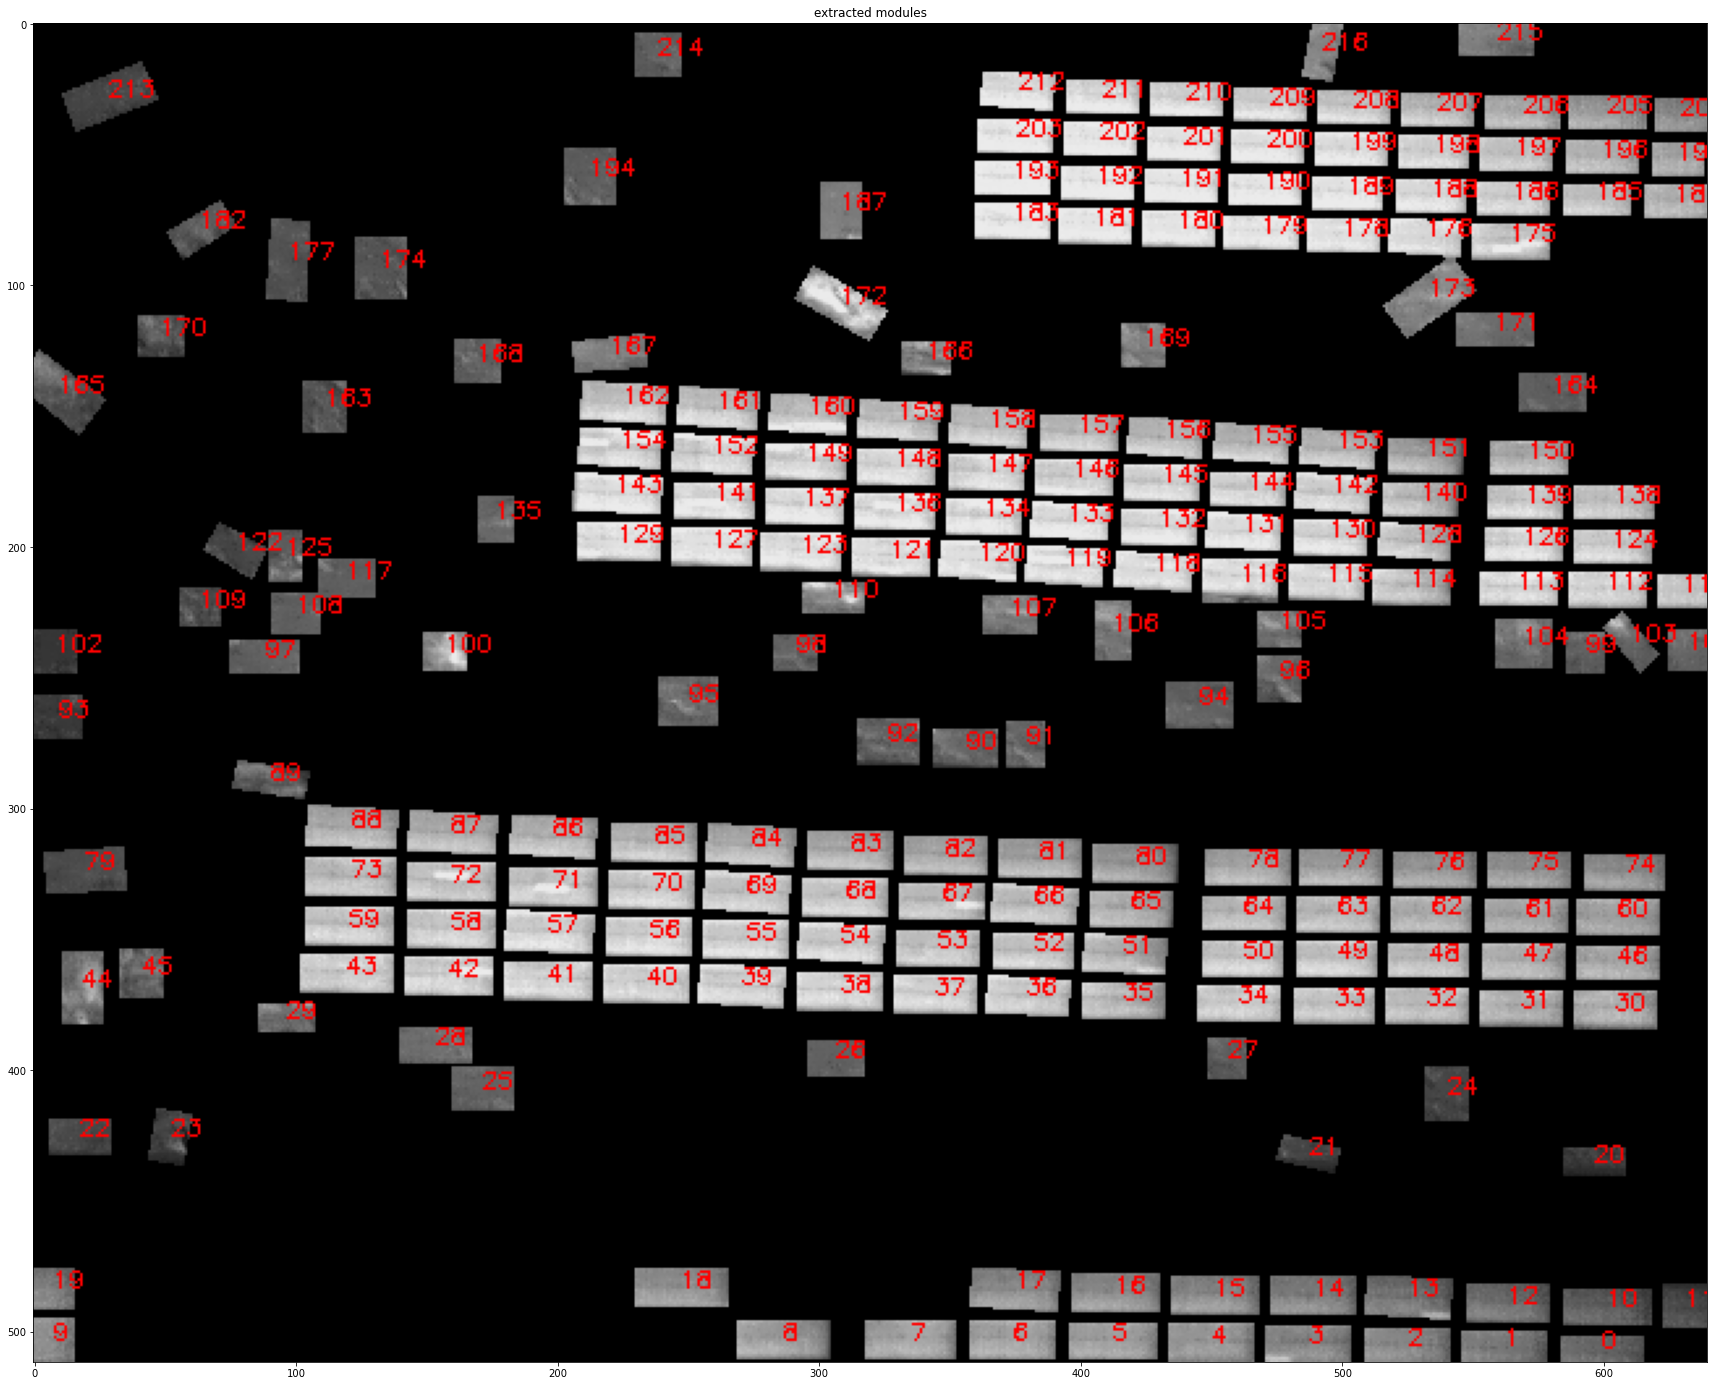

In [14]:
module_extraction.show_img({"extracted modules":img_mask_index},cmap="gray",figsize=(30,30))

In [15]:
module_indices = list(map(lambda x: np.int(x.split(".")[0]), thermal_img_files.keys()))
module_contours = [modules.panel_contours[idx] for idx in module_indices]
module_labels = modules.get_string_anomaly_labels(module_contours)

(512.0, 0.0)

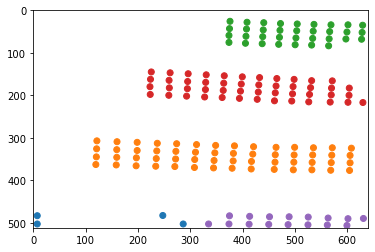

In [16]:
fig, ax = plt.subplots(facecolor="w")
cmap = plt.get_cmap("tab10")
module_centers = np.array( [c.mean(axis=0) for c in module_contours] )
plt.scatter(module_centers[:, 0], module_centers[:, 1], color=cmap(module_labels+1))
ax.set_xlim([0, img_con.shape[1]])
ax.set_ylim([img_con.shape[0], 0])

温度分布の確認

In [17]:
data = ThermalData(thermal_img_files, scale_type="individual")

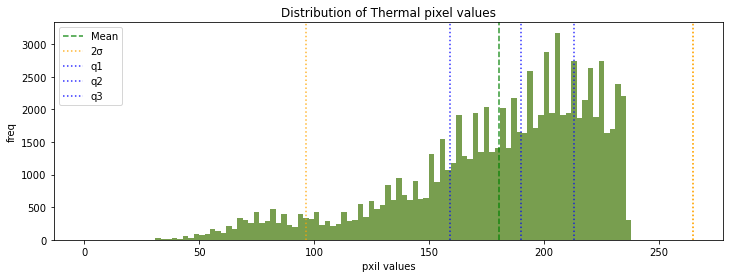

In [18]:
display.display_distributions(data.all_temperature, 
                              filepath = "hist_all_temperature.jpg")

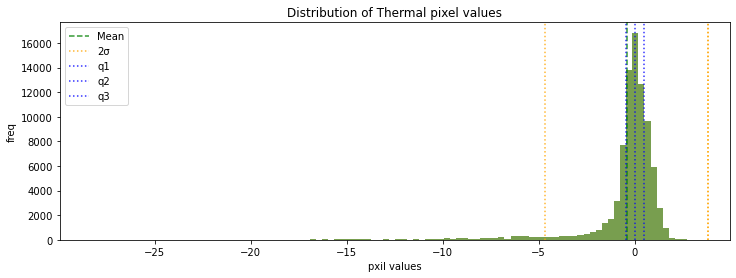

In [20]:
display.display_distributions(data.scaled_all_temperature,
                              filepath = "hist_scaled_all_temperature.jpg")

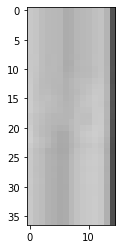

In [21]:
for k, v in list(thermal_img_files.items())[:1]:
    plt.imshow(v)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


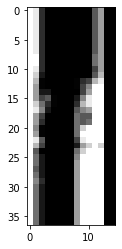

In [22]:
for k, v in list(thermal_img_files.items())[:1]:
    plt.imshow(data.transformed_temperature[k].reshape(v.shape))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


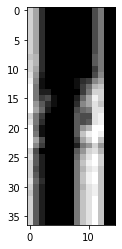

In [23]:
for k, v in list(thermal_img_files.items())[:1]:
    plt.imshow(data.scaled_temperature[k].reshape(v.shape))

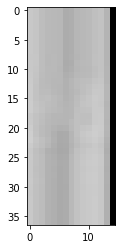

In [24]:
for k, v in list(thermal_img_files.items())[:1]:
    mask = (data.scaled_temperature[k] > -2).reshape(v.shape)
    plt.imshow(v * mask)

温度分布の確認（アレイごと）

In [25]:
from sklearn import preprocessing

In [26]:
# This will be implemented in ThermalData class
data_array = {}; array_scaler= {}; 
threshold_upper_bound = {}
threshold_lower_bound = {}
for c in range(-1,max(module_labels)+1):
    indices = np.where(module_labels==c)
    target_thermal_img_files = pd.Series(thermal_img_files).iloc[indices]
    data_array[c] = ThermalData(target_thermal_img_files, scale_type="individual")
    rscaler = preprocessing.RobustScaler()
    array_scaler[c] = rscaler.fit(data_array[c].all_temperature)    

module label: -1


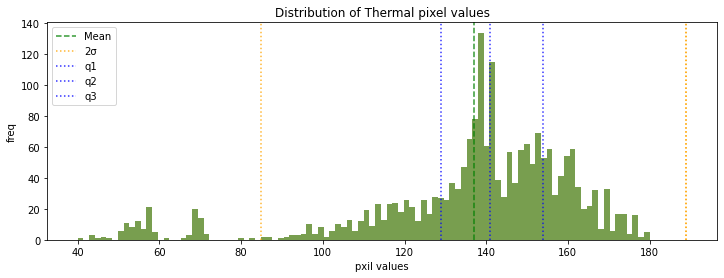

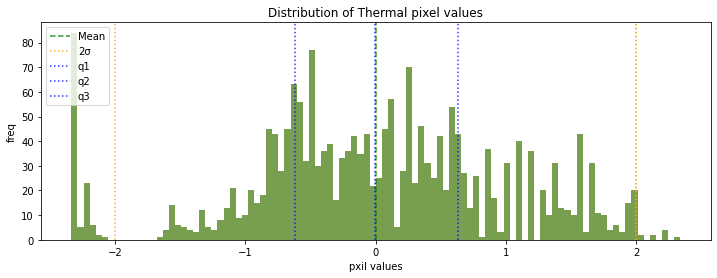

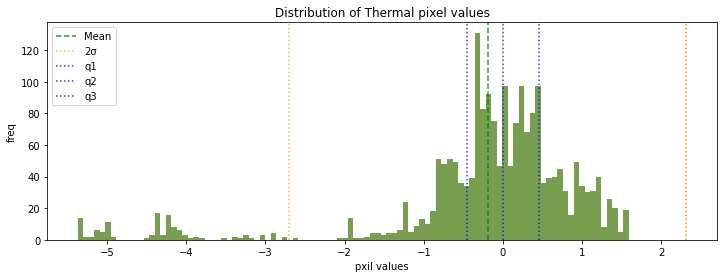

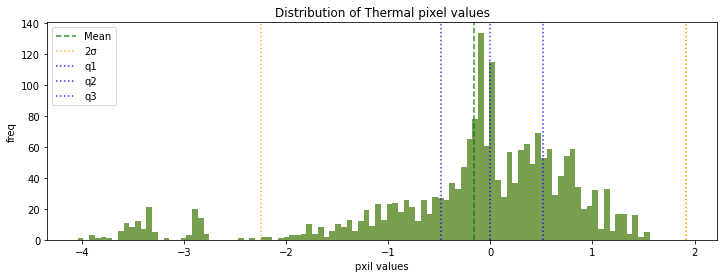

module label: 0


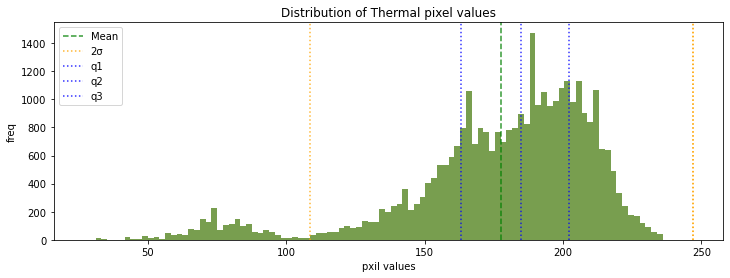

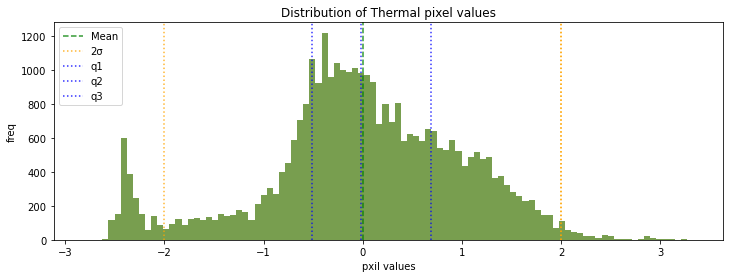

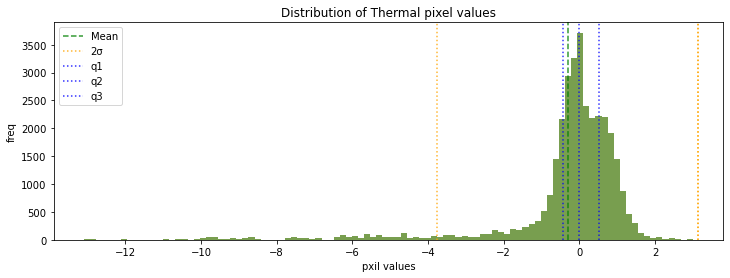

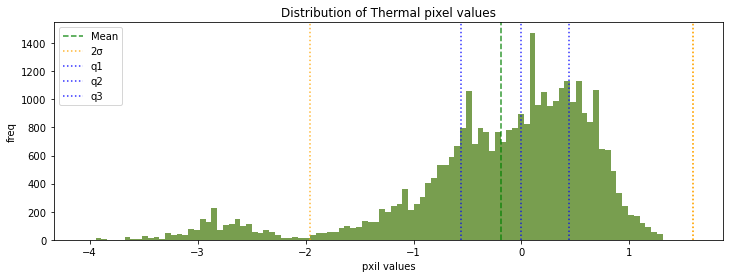

module label: 1


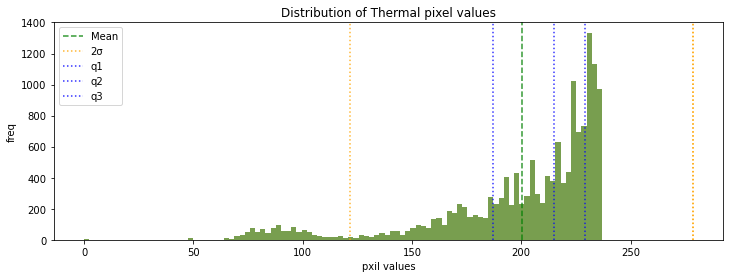

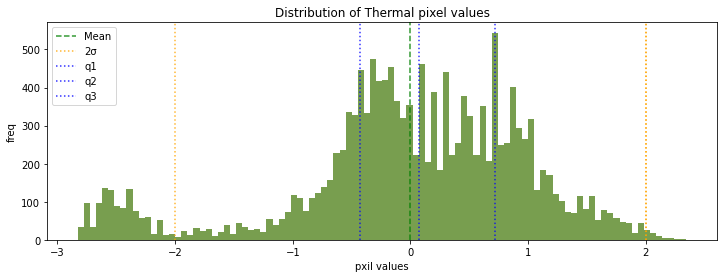

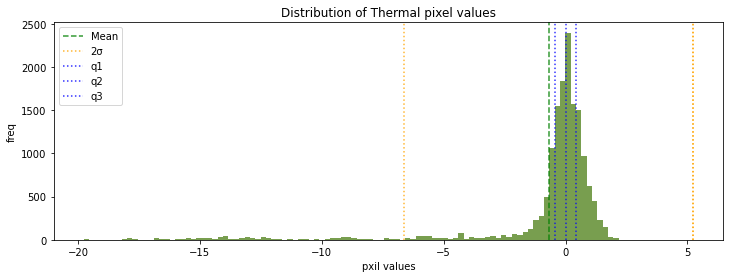

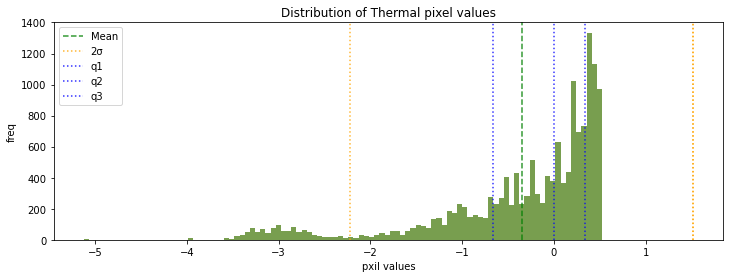

module label: 2


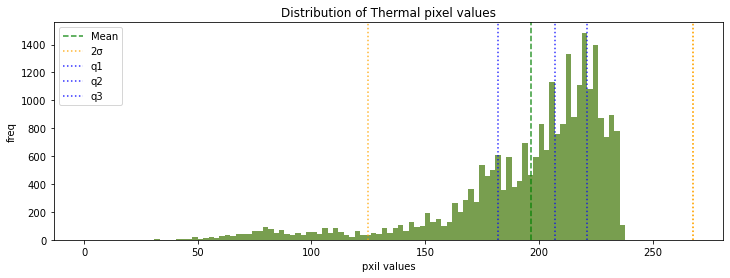

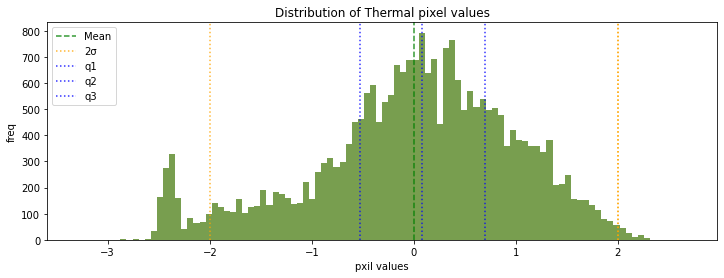

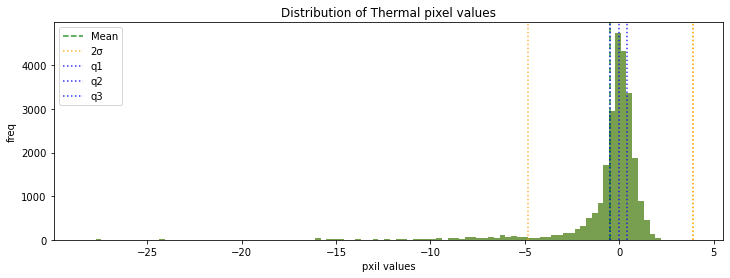

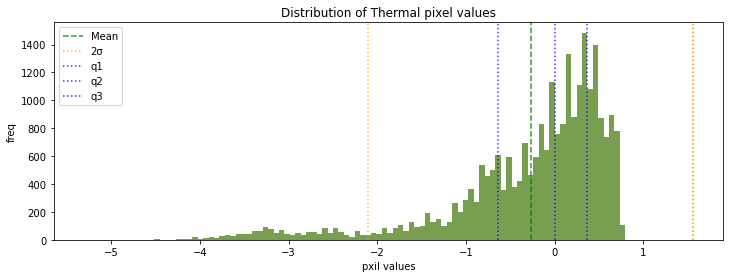

module label: 3


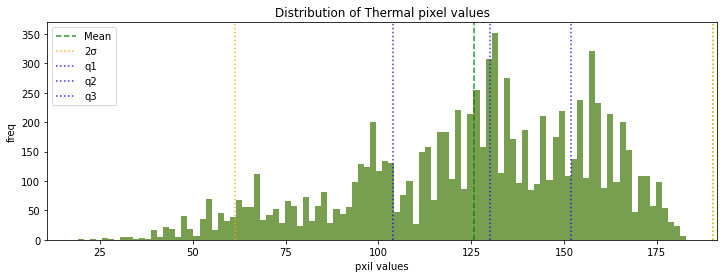

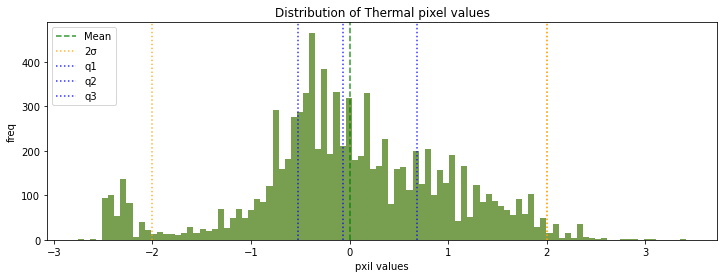

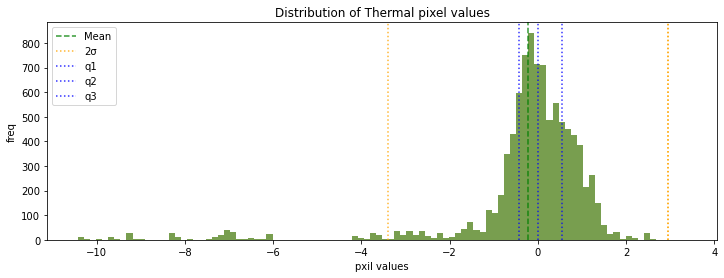

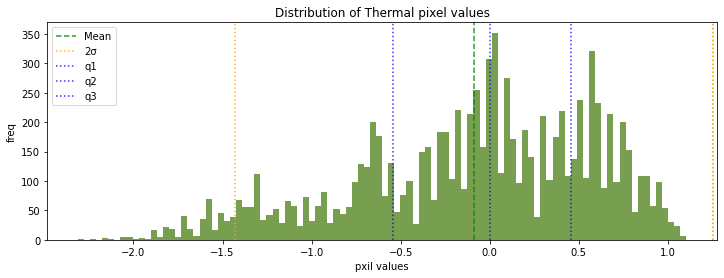

In [27]:
for k, v in data_array.items():
    print("module label:",k)
    display.display_distributions(v.all_temperature, 
                              filepath = "hist_all_temperature.jpg")
    display.display_distributions(v.scaled_all_temperature, 
                              filepath = "hist_scaled_all_temperature.jpg")        
    display.display_distributions(array_scaler[k].transform(v.all_temperature), 
                              filepath = "hist_transformed_all_temperature.jpg")

異常タイプの確認テスト

In [28]:
def get_hotspots_in_array(clusters_temperature, array_id, img_file, log=False):
    # -- hot cluster --
    transformed_temperature = array_scaler[array_id].transform(clusters_temperature)
    hot_clusters = (transformed_temperature.mean(axis=1) > 1.3)
    # -- hot pixcel --
    hot_pixels = np.array([c in np.where(hot_clusters==True)[0] for c in clusters.labels])
    hot_pixels = hot_pixels.reshape(*img_file.shape[:2],1)      
    if log:
        print("Hot cluster labels in array:",hot_clusters)
        print("Hotspot weights in array:",hot_pixels.mean())
    return hot_pixels, hot_clusters

In [29]:
def get_hotspots_in_module(scaled_clusters_temperature,  img_file, log=False):
    # -- hot cluster --
    hot_clusters = (scaled_clusters_temperature.mean(axis=1) > 1.3)
    # -- hot pixcel --
    hot_pixels = np.array([c in np.where(hot_clusters==True)[0] for c in clusters.labels])
    hot_pixels = hot_pixels.reshape(*img_file.shape[:2],1)      
    if log:
        print("Hot cluster labels in module:",hot_clusters)
        print("Hotspot weights in module:",hot_pixels.mean())
    return hot_pixels, hot_clusters

In [30]:
clustering_method="kmeans"
#clustering_method="xmeans" # not stable
#clustering_method="dbscan"

******* start *******
63.jpg
Module type: Normal


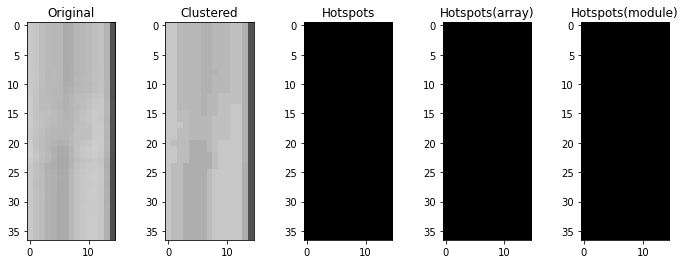

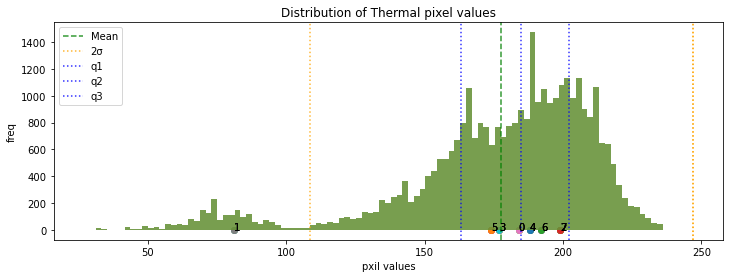

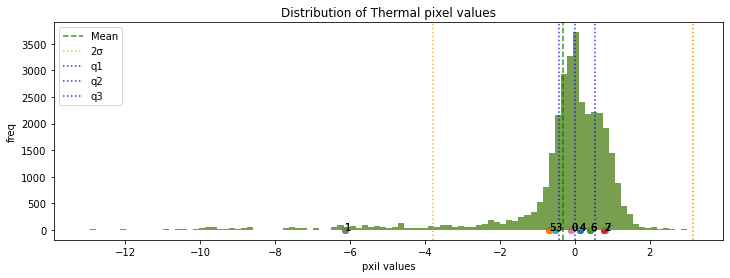

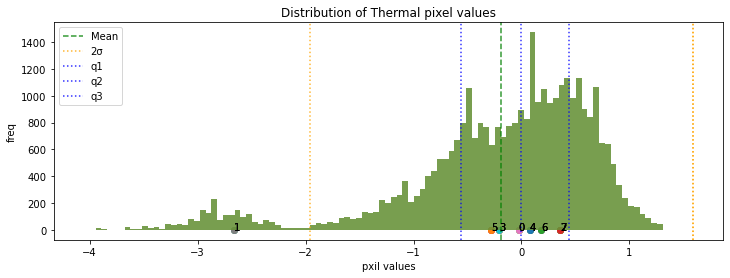

******* end *******
******* start *******
189.jpg
Module type: Normal


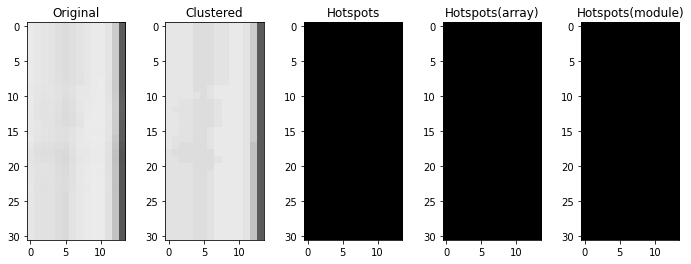

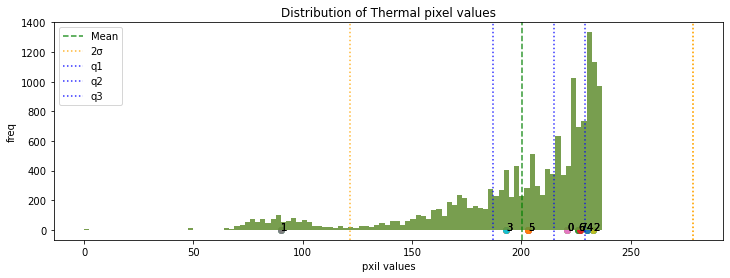

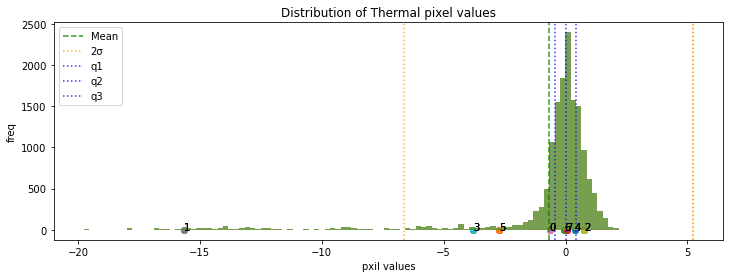

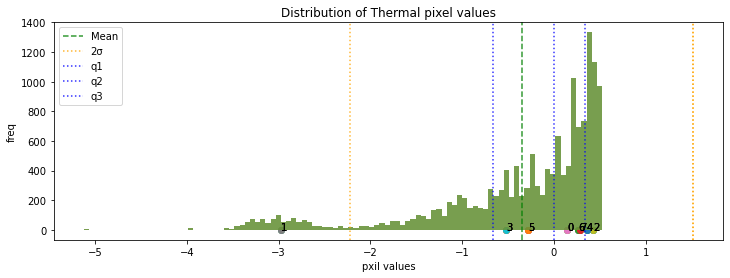

******* end *******
******* start *******
77.jpg
Module type: Normal


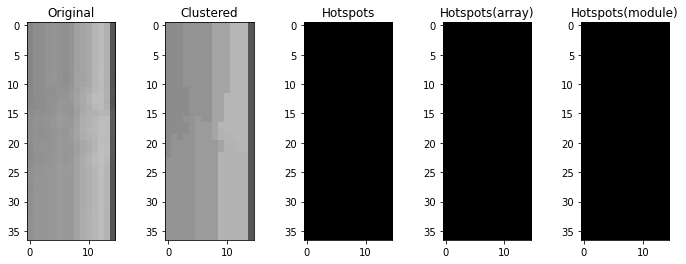

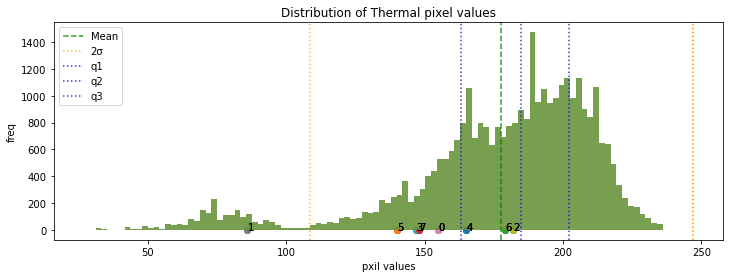

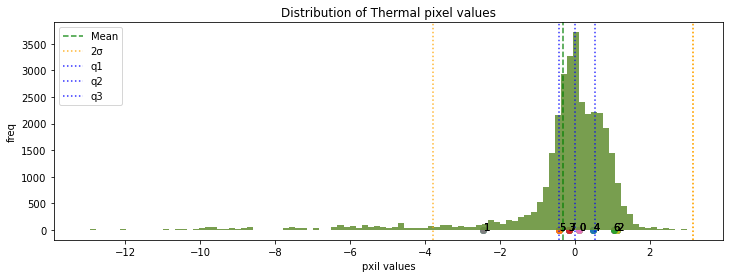

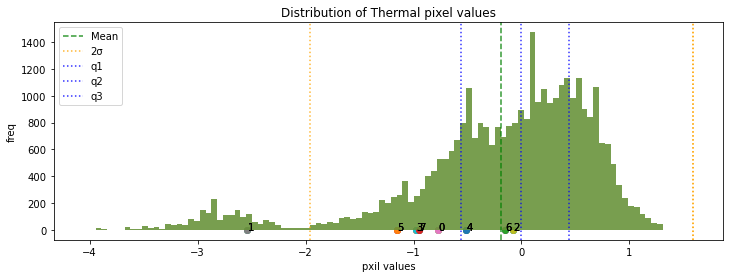

******* end *******
******* start *******
162.jpg
Module type: Normal


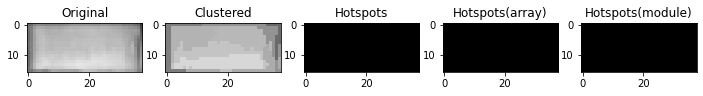

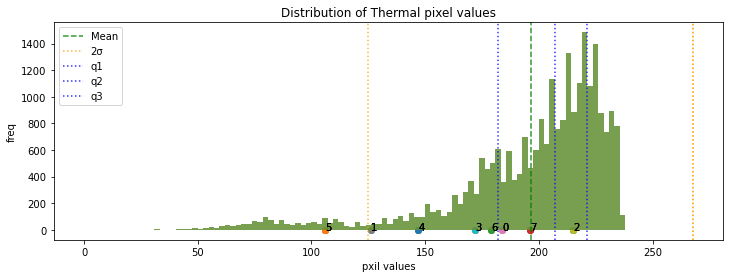

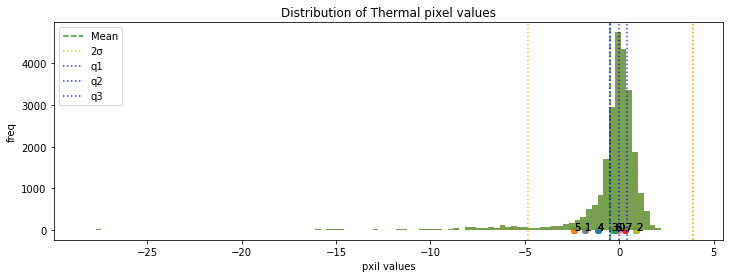

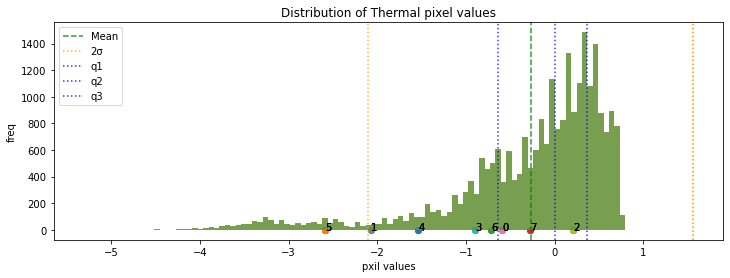

******* end *******
******* start *******
176.jpg
Module type: Normal


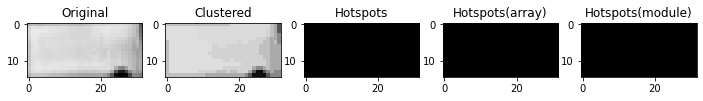

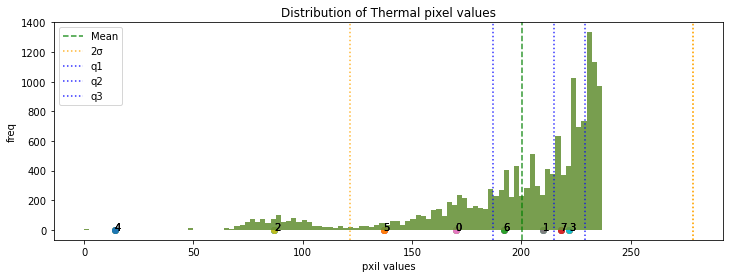

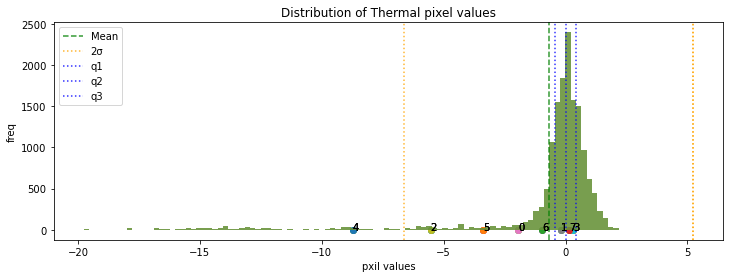

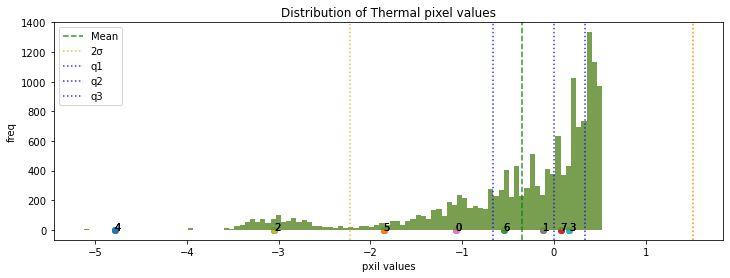

******* end *******
******* start *******
88.jpg
Module type: Normal


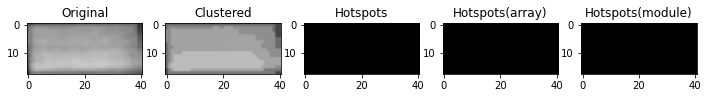

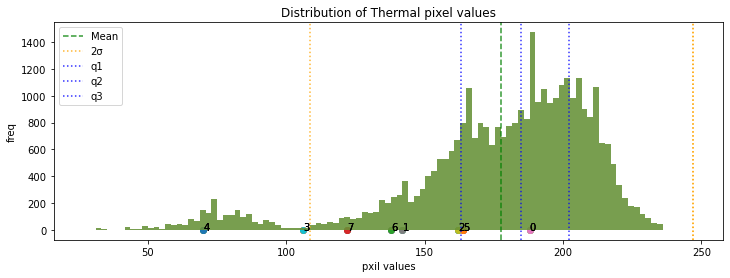

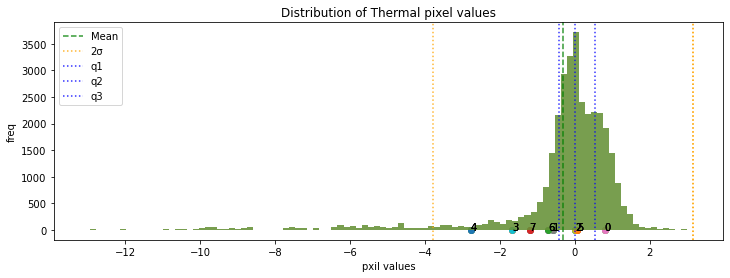

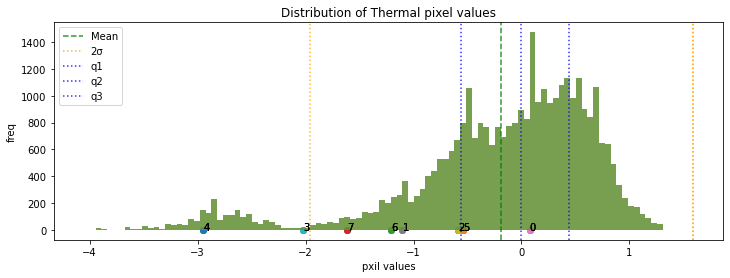

******* end *******
******* start *******
200.jpg
Module type: Normal


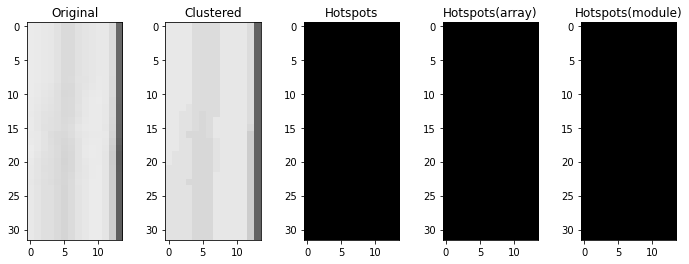

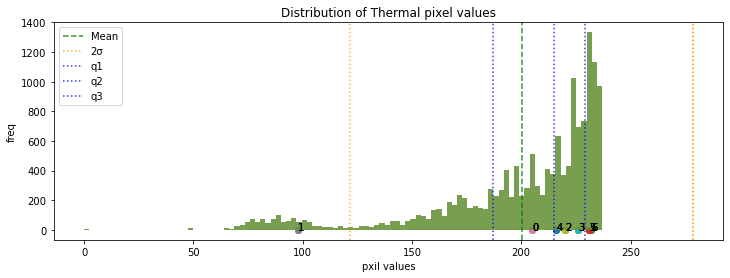

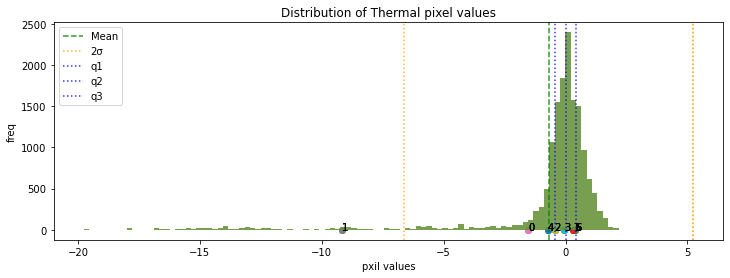

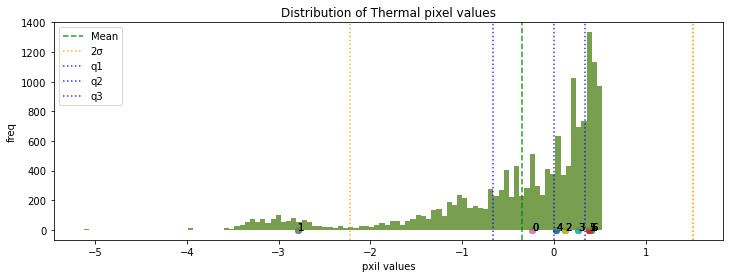

******* end *******
******* start *******
201.jpg
Module type: Normal


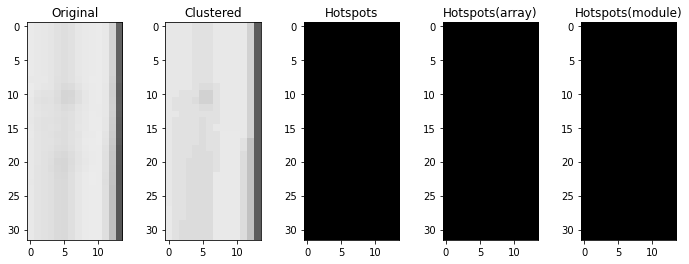

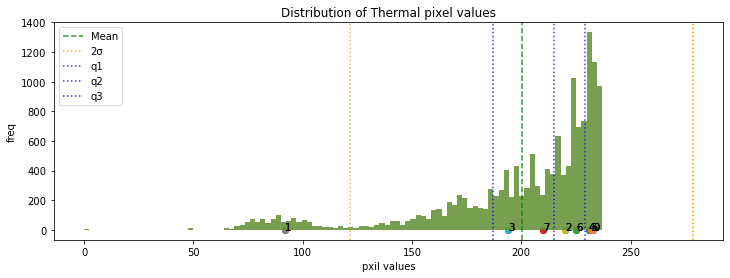

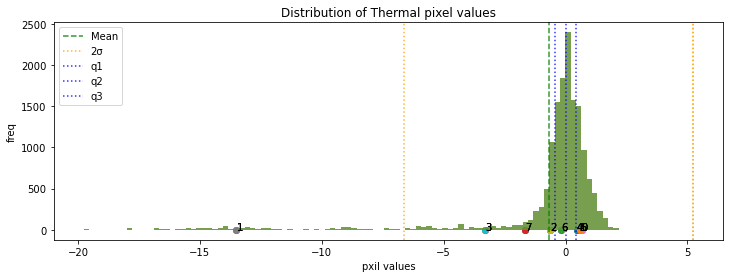

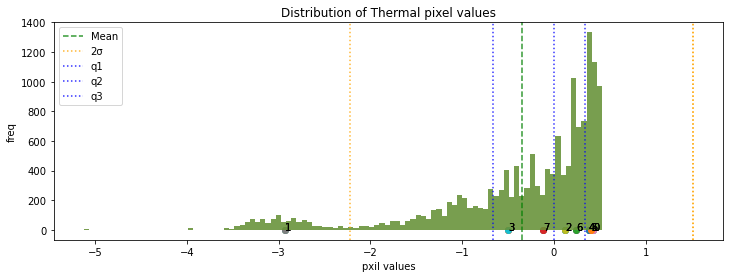

******* end *******
******* start *******
188.jpg
Module type: Normal


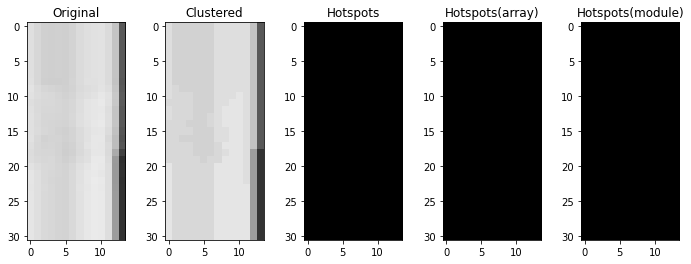

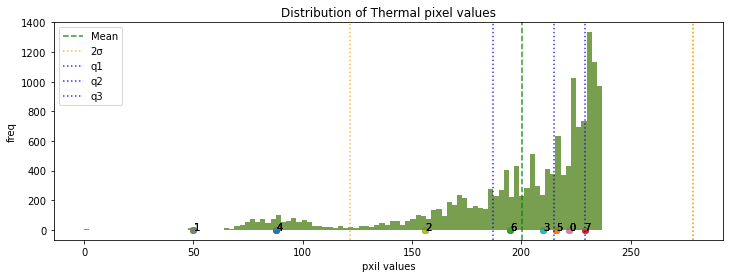

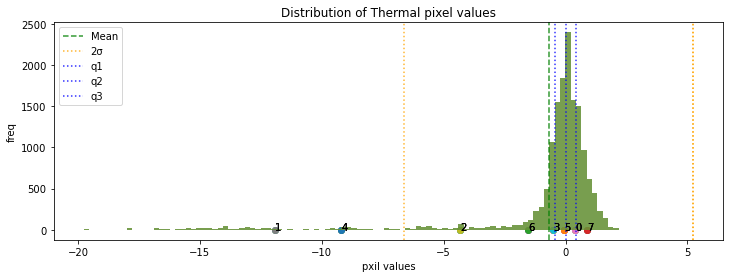

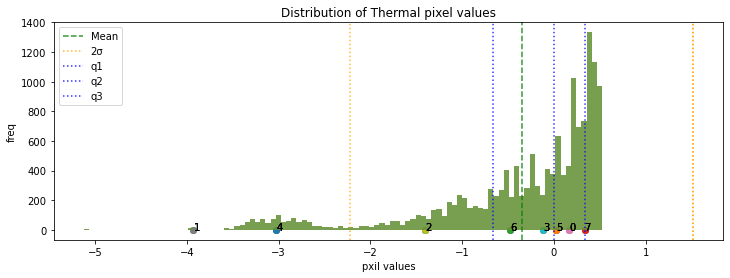

******* end *******
******* start *******
76.jpg
Module type: Normal


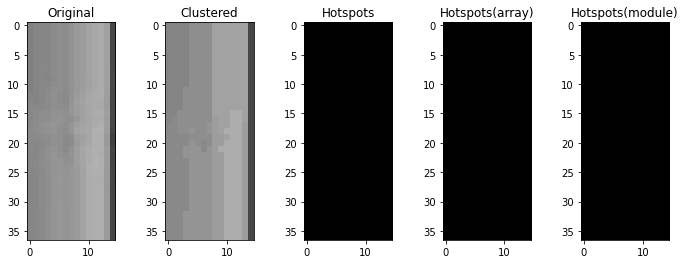

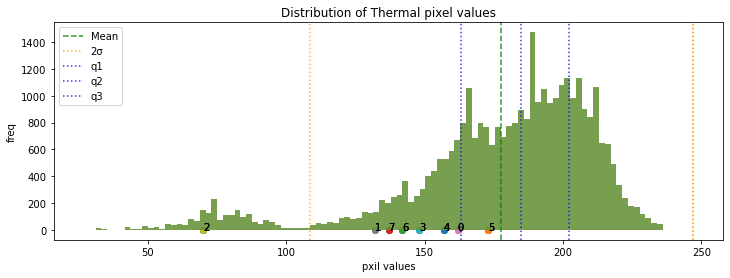

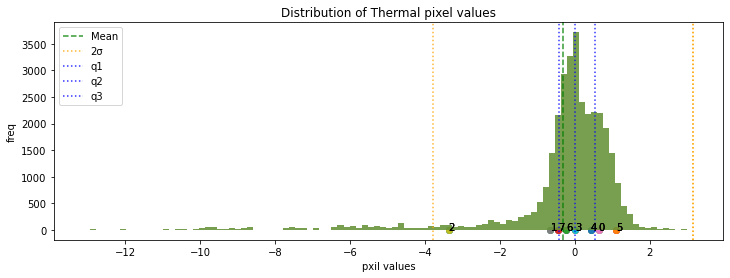

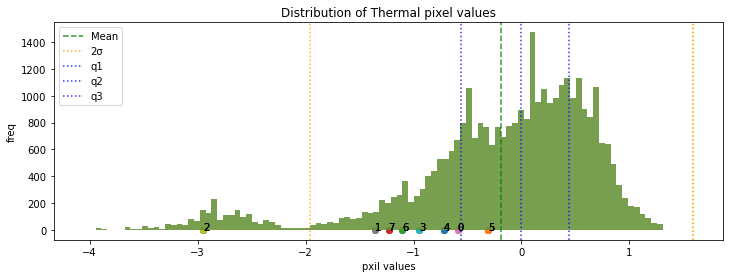

******* end *******
******* start *******
62.jpg
Module type: Normal


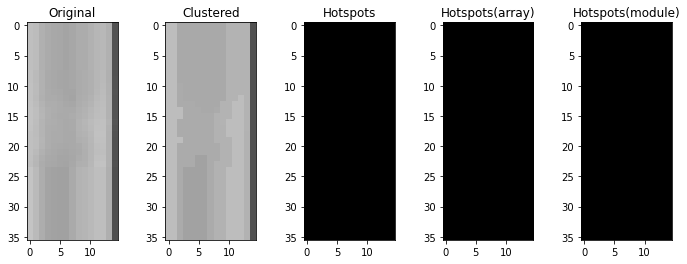

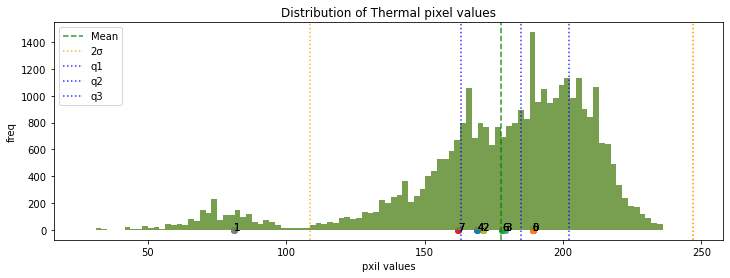

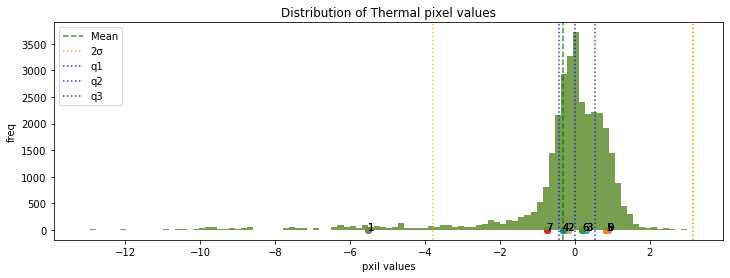

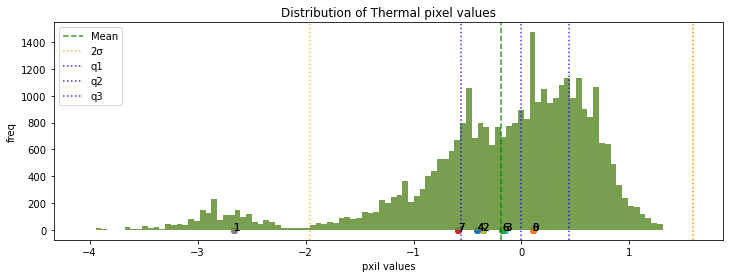

******* end *******
******* start *******
74.jpg
Module type: Normal


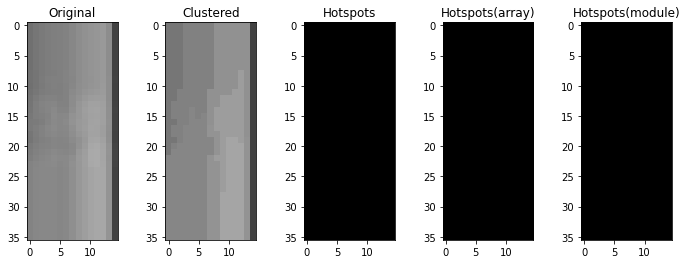

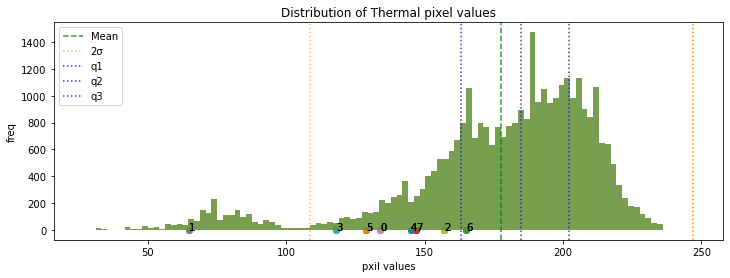

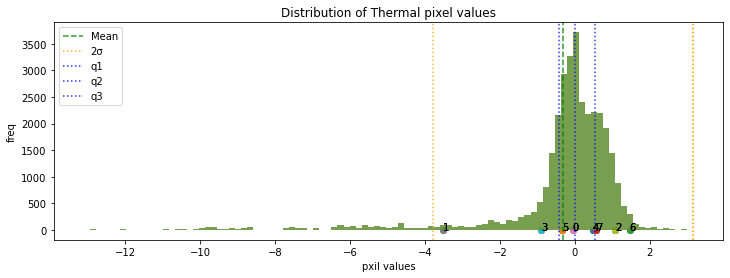

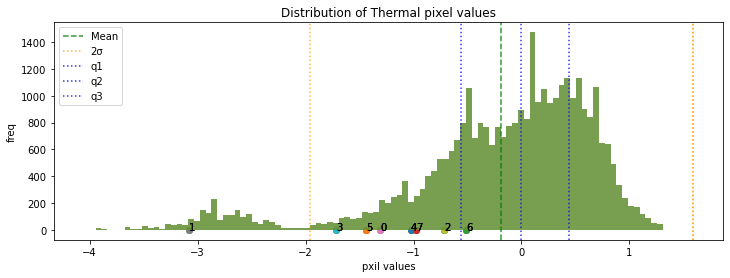

******* end *******
******* start *******
60.jpg
Module type: Single-Hotspot


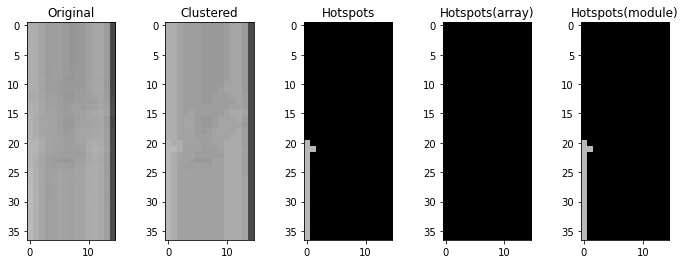

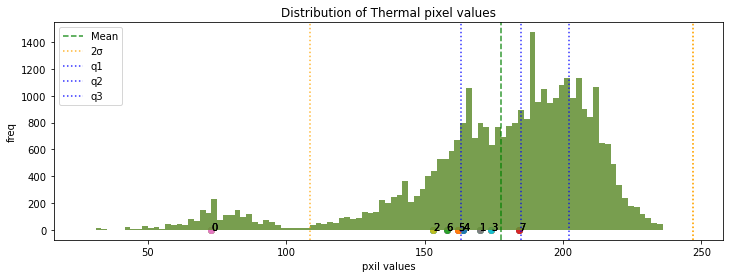

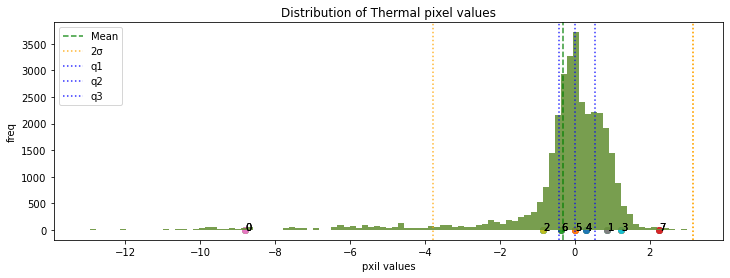

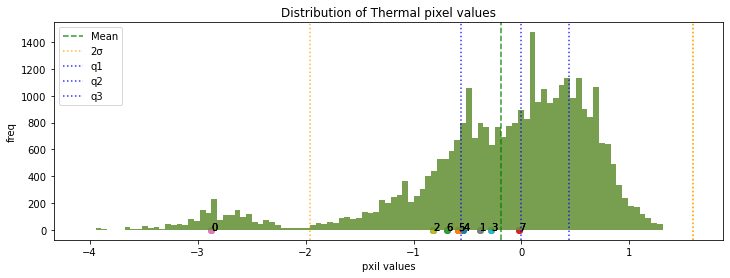

******* end *******
******* start *******
48.jpg
Module type: Normal


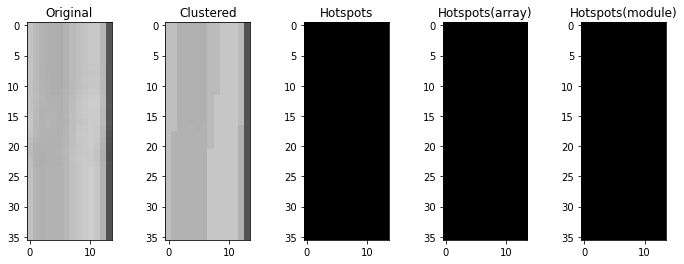

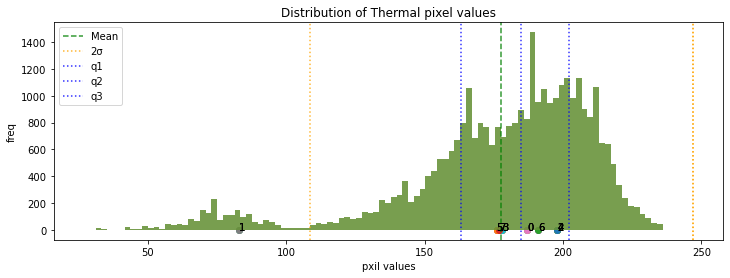

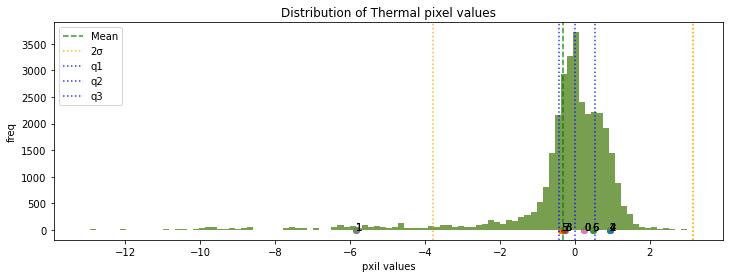

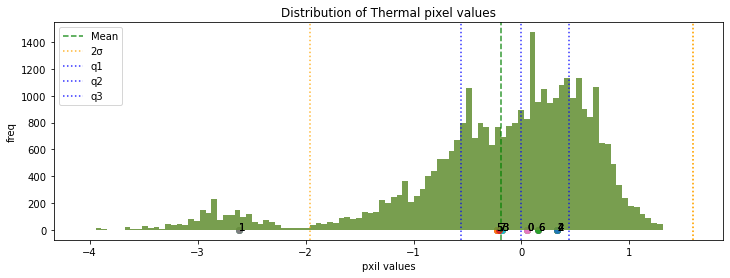

******* end *******
******* start *******
149.jpg
Module type: Normal


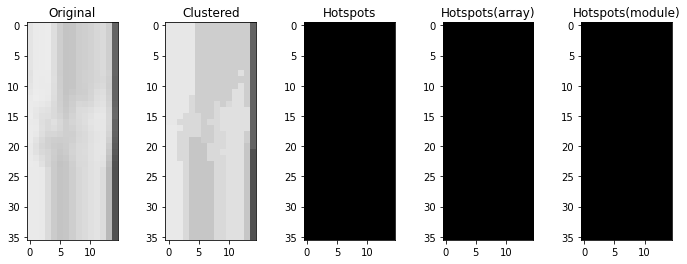

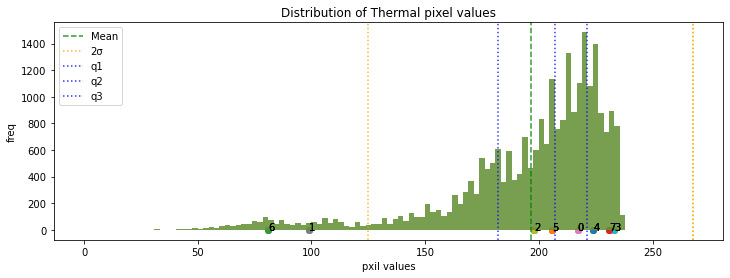

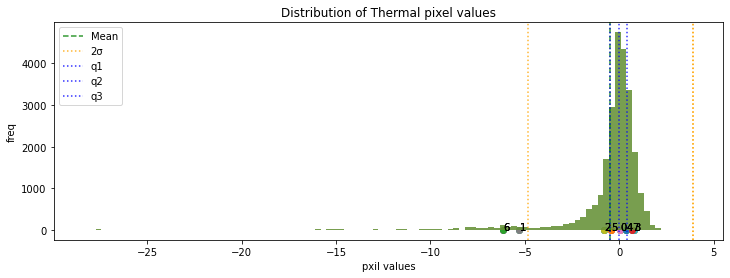

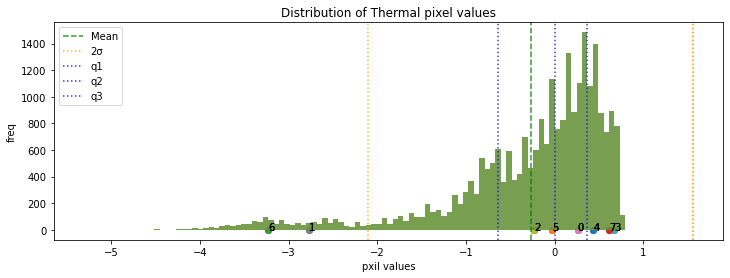

******* end *******
******* start *******
175.jpg
Module type: Single-Hotspot


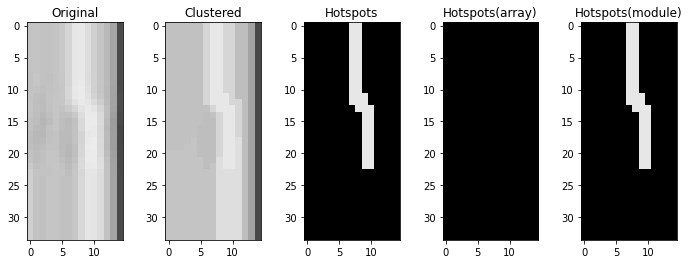

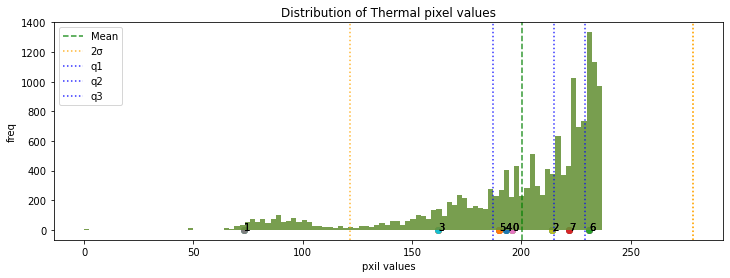

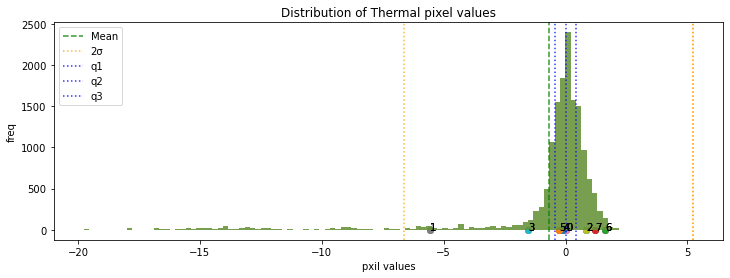

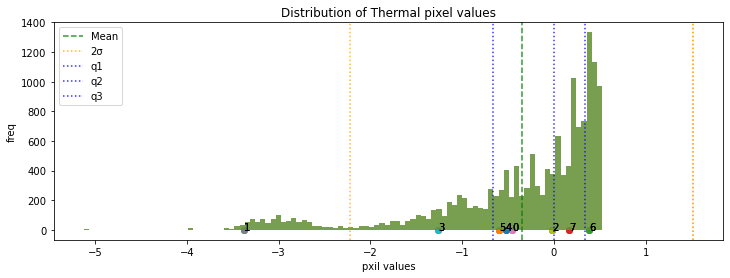

******* end *******
******* start *******
161.jpg
Module type: Normal


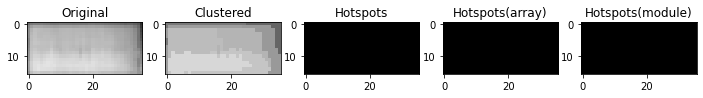

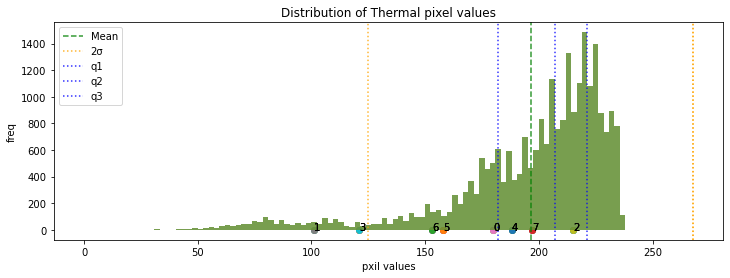

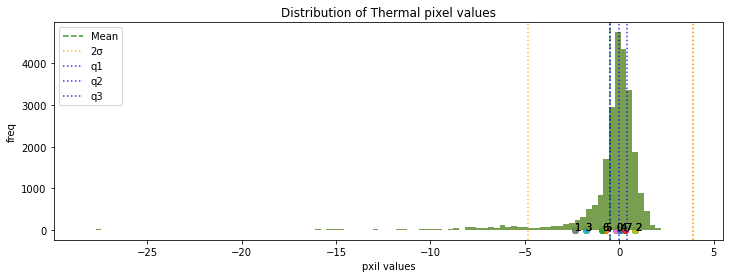

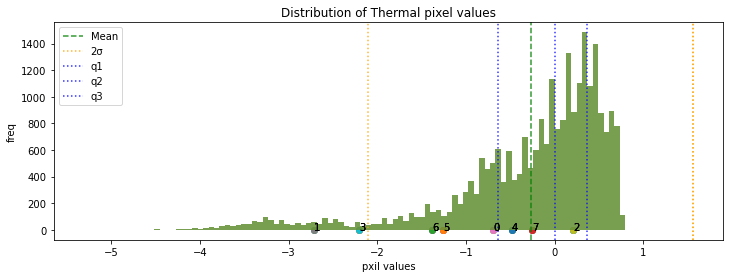

******* end *******
******* start *******
203.jpg
Module type: Normal


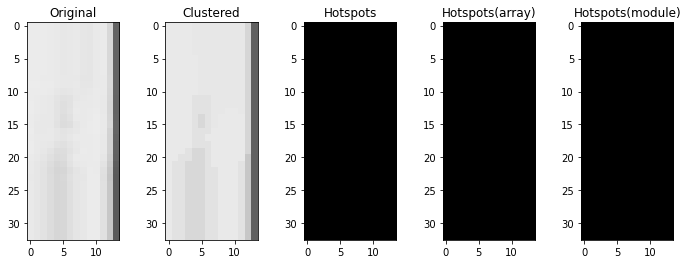

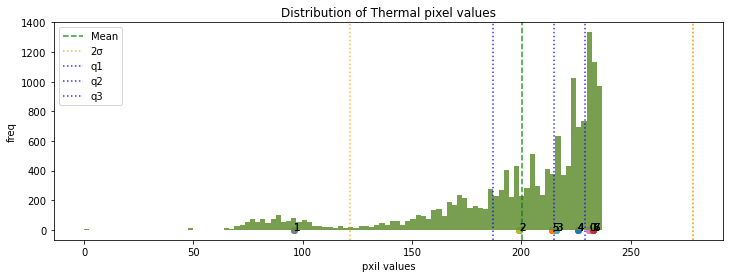

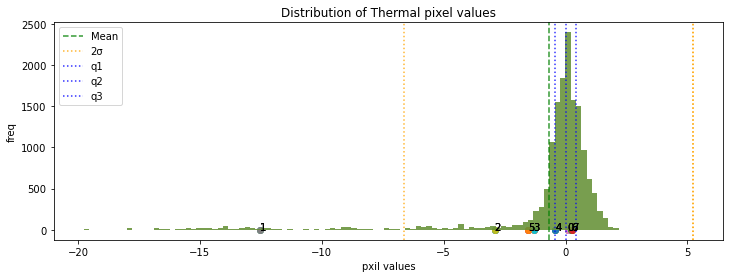

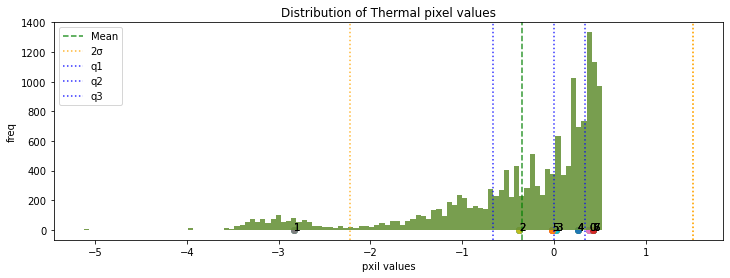

******* end *******
******* start *******
202.jpg
Module type: Normal


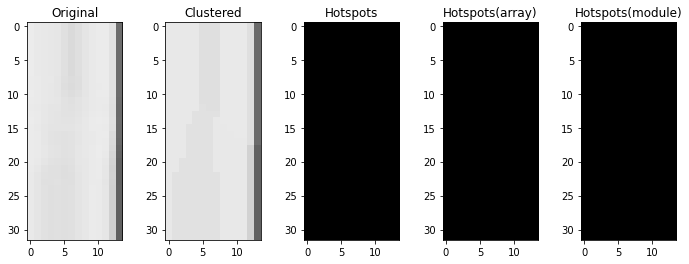

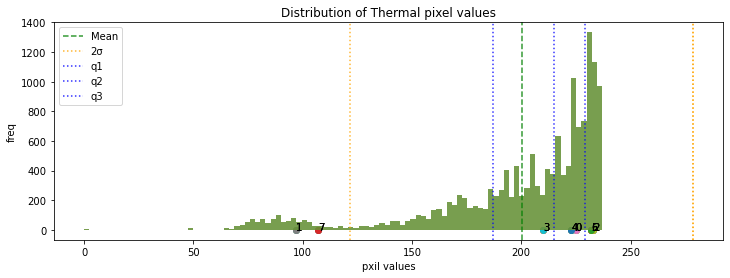

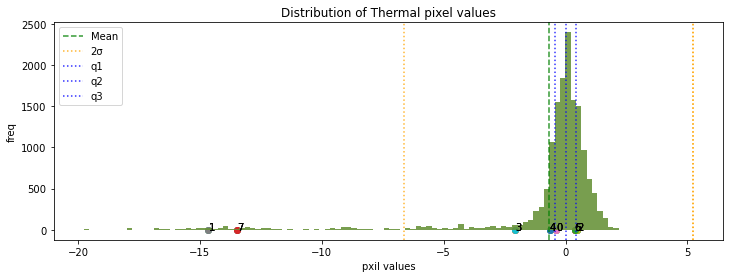

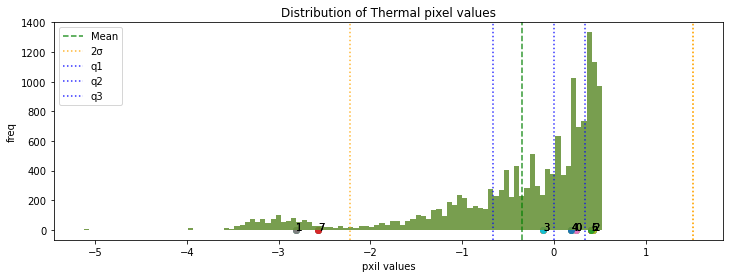

******* end *******
******* start *******
160.jpg
Module type: Normal


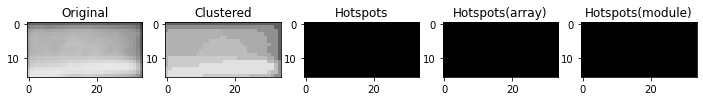

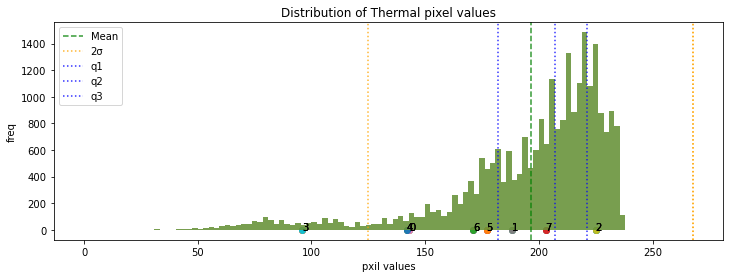

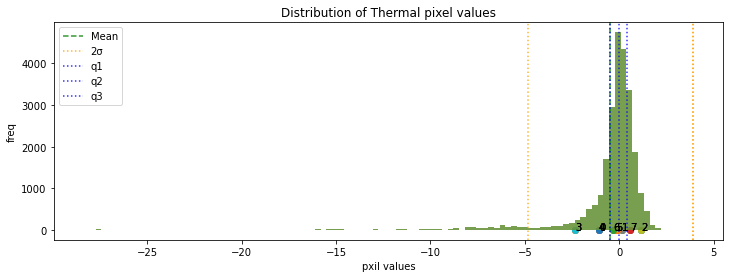

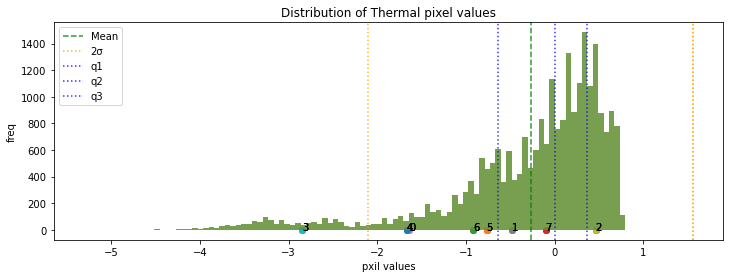

******* end *******
******* start *******
148.jpg
Module type: Normal


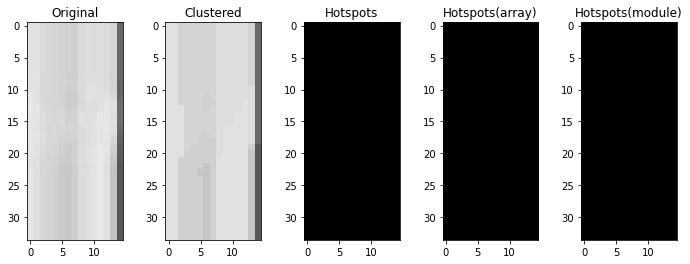

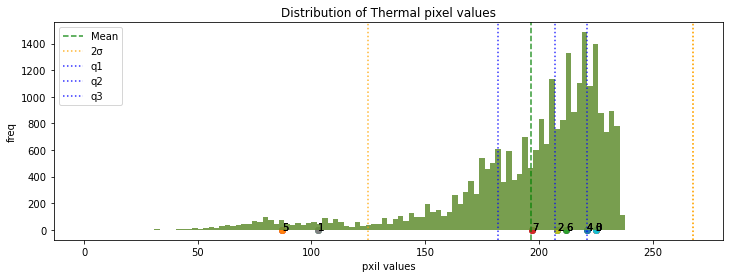

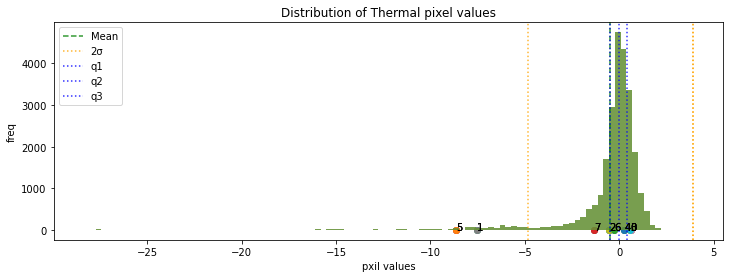

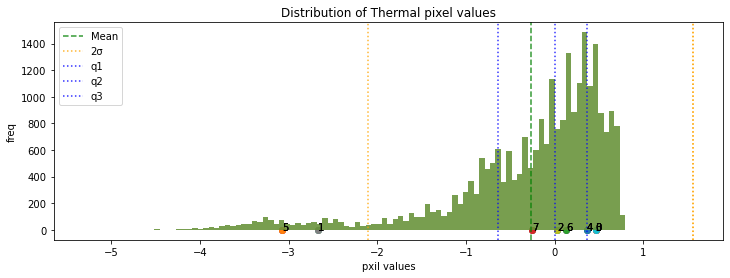

******* end *******
******* start *******
49.jpg
Module type: Normal


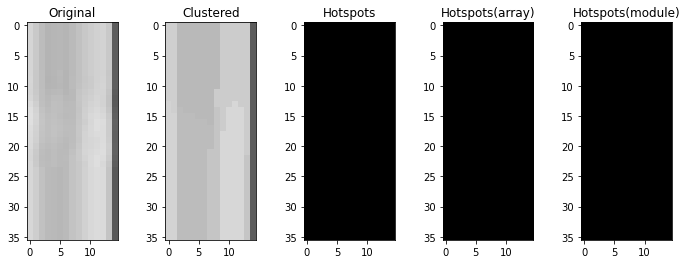

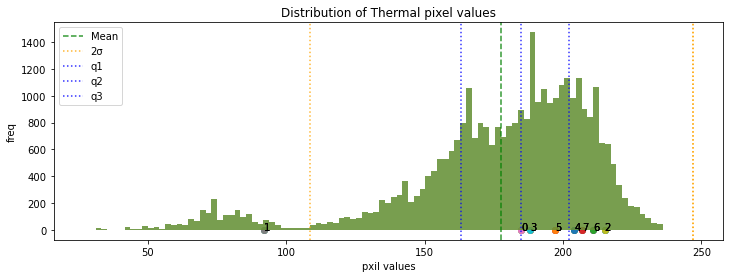

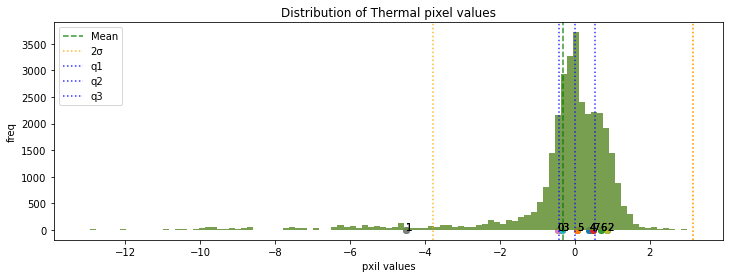

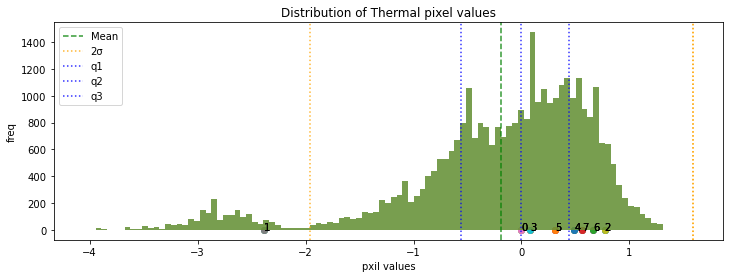

******* end *******
******* start *******
61.jpg
Module type: Normal


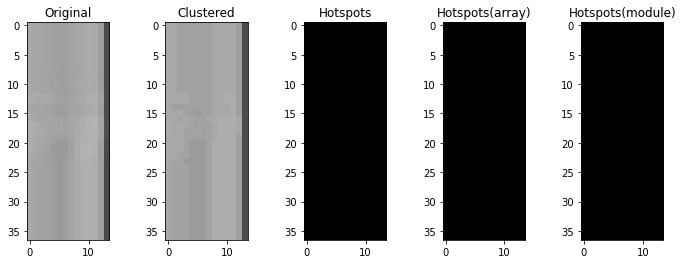

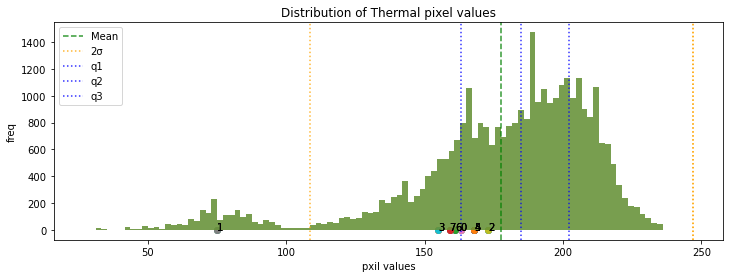

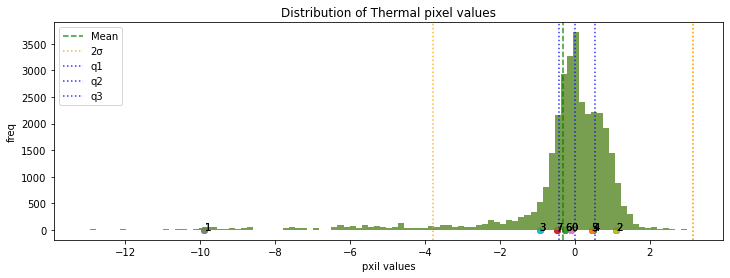

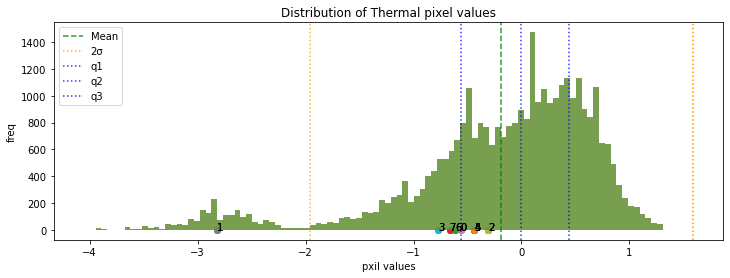

******* end *******
******* start *******
75.jpg
Module type: Normal


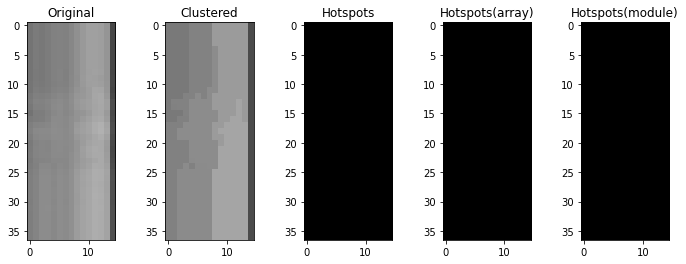

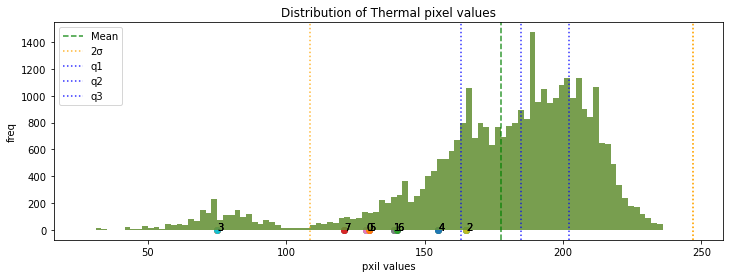

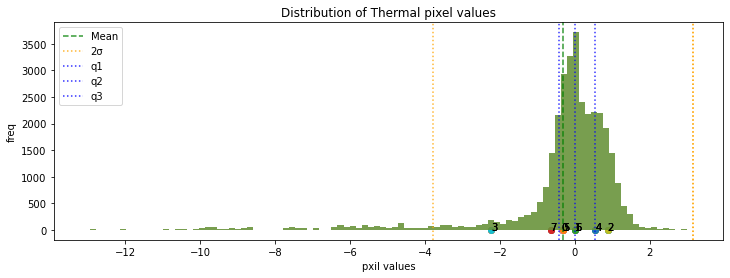

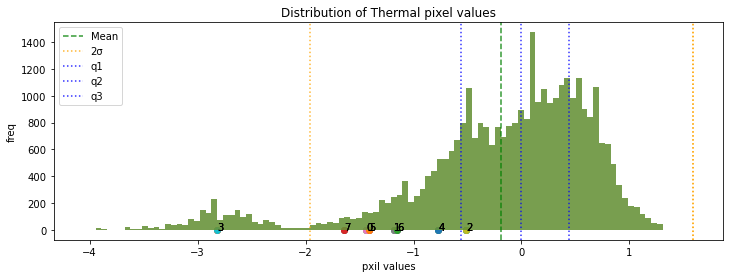

******* end *******
******* start *******
59.jpg
Module type: Normal


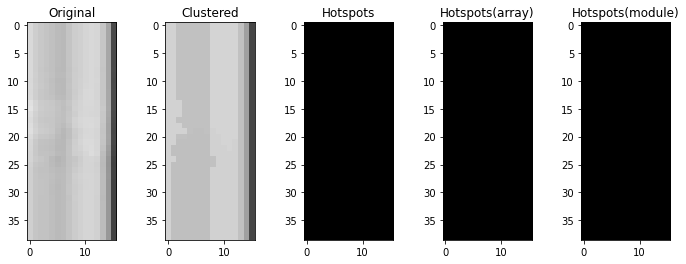

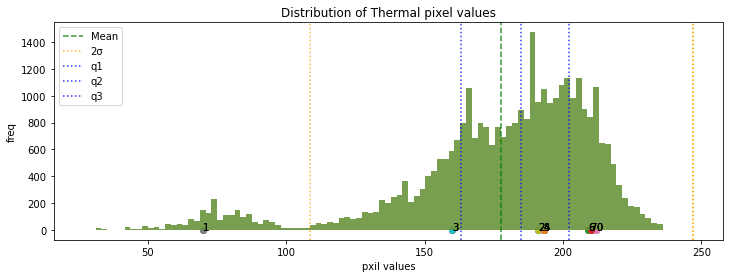

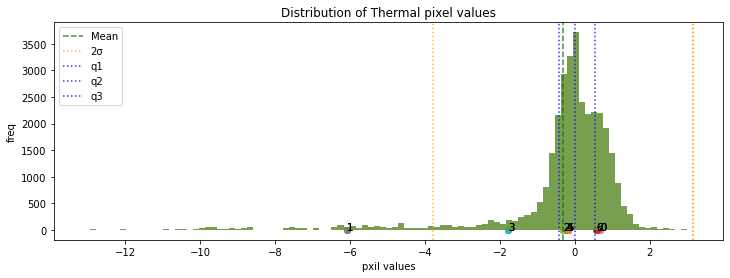

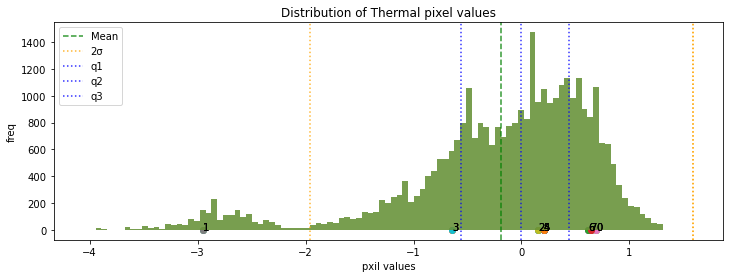

******* end *******
******* start *******
71.jpg
Module type: Normal


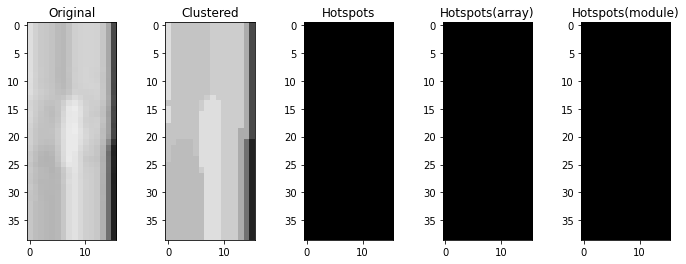

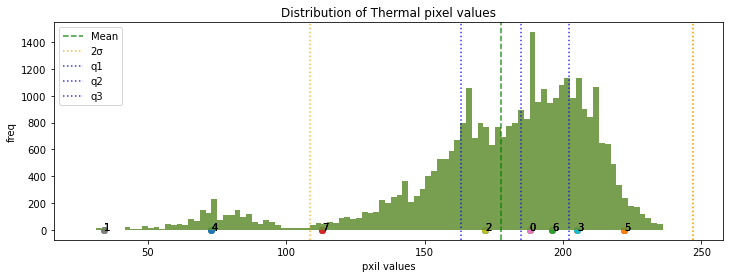

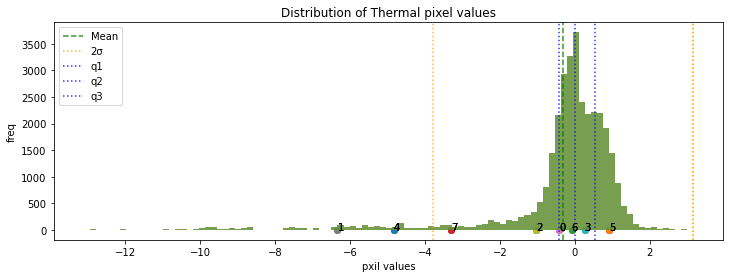

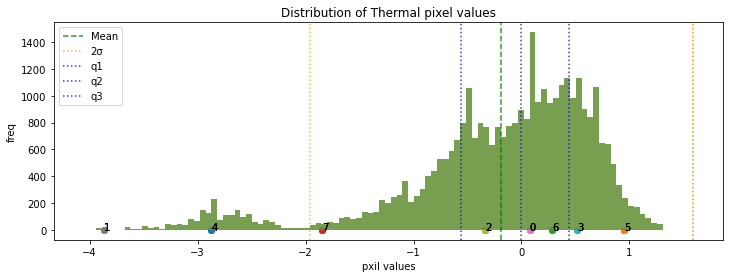

******* end *******
******* start *******
65.jpg
Module type: Normal


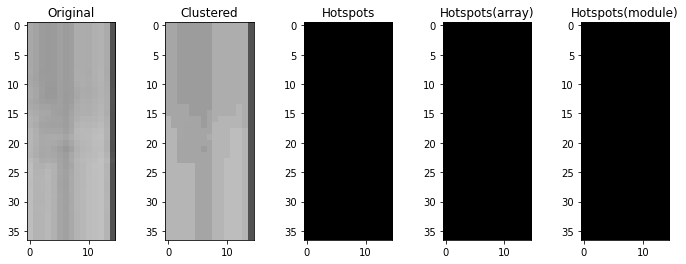

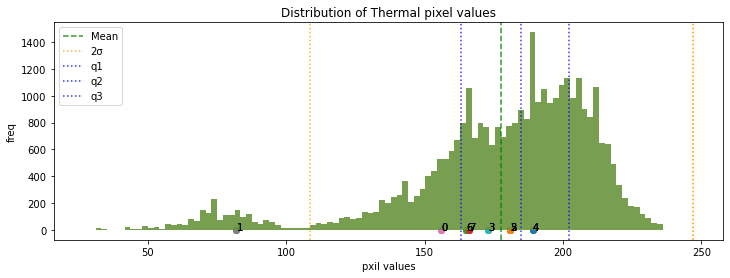

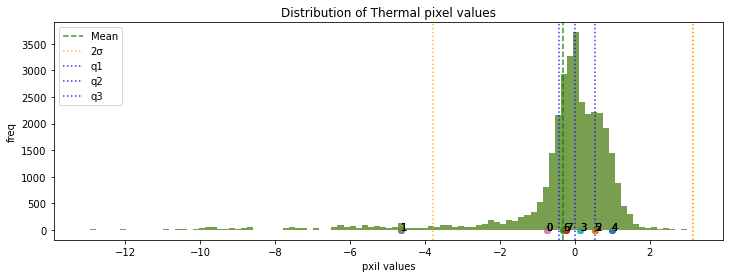

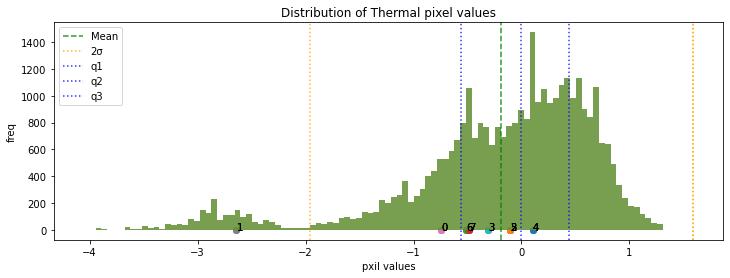

******* end *******
******* start *******
158.jpg
Module type: Normal


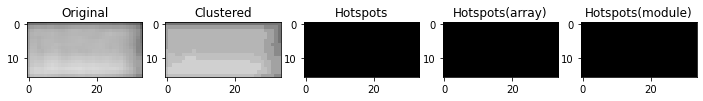

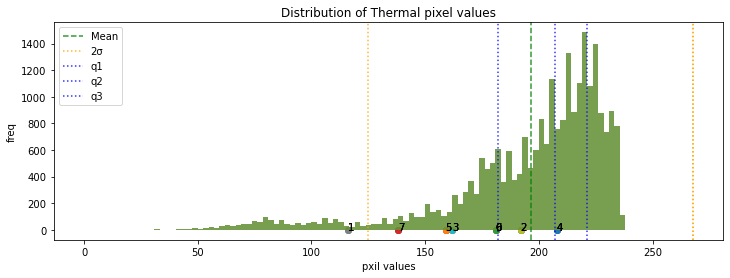

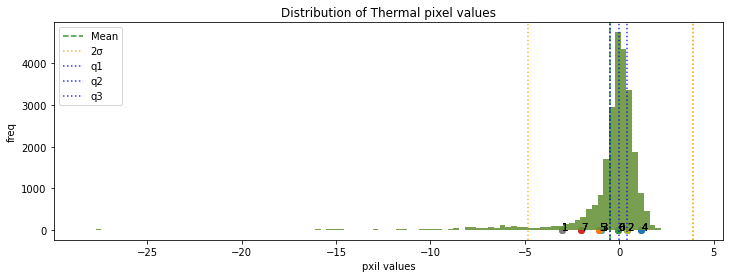

In [ ]:
anomaly_modules= {}
#for n, k in enumerate(list(thermal_img_files)[:1]):
for n, k in enumerate(list(thermal_img_files)):    
    print("******* start *******")
    print(k)
    # -- module label --
    l = module_labels[n]
    # -- cluster temperature ---
    clusters = clustering.TemperatureClusters(
        data_array[l].scaled_temperature_with_index[k], method=clustering_method)  
    # -- original cluster --
    sliced_data = clusters.get_clusters_data(data_array[l].temperature[k])    
    original_clusters_temperature = np.stack([np.uint8(t.mean(axis=0)) for t in sliced_data])
    # -- scaled cluster --
    sliced_data = clusters.get_clusters_data(data_array[l].scaled_temperature[k])
    scaled_clusters_temperature = np.stack([t.mean(axis=0) for t in sliced_data ])
    # -- anomaly detection --    
    hot_pixels_in_array, hot_clusters_in_array = get_hotspots_in_array(
        original_clusters_temperature, l, thermal_img_files[k], log=False) 
    hot_pixels_in_module, hot_clusters_in_module = get_hotspots_in_module(
        scaled_clusters_temperature, thermal_img_files[k], log=False)
    hot_pixels = (hot_pixels_in_array | hot_pixels_in_module)
    hot_clusters = (hot_clusters_in_array | hot_clusters_in_module)
    module_type = anomaly_detection.detect_module_type(hot_clusters, hot_pixels)
    print("Module type:", module_type)
    # -- save anomaly modules --
    if module_type not in anomaly_modules:
        anomaly_modules[module_type] = [k]
    else:
        anomaly_modules[module_type].append(k)
    # -- display -- 
    #img_scaled = data_array[l].scaled_temperature[k].reshape(thermal_img_files[k].shape)
    img_clustered = original_clusters_temperature[clusters.labels].reshape(thermal_img_files[k].shape)
    img_hotspots = img_clustered * hot_pixels
    img_hotspots_in_array = img_clustered * hot_pixels_in_array
    img_hotspots_in_module = img_clustered * hot_pixels_in_module
    display.display_modules({
        "Original": thermal_img_files[k], 
        "Clustered": img_clustered,
        "Hotspots": img_hotspots,
        "Hotspots(array)": img_hotspots_in_array,
        "Hotspots(module)": img_hotspots_in_module,
    })
    display.display_distributions(
        data_array[l].all_temperature,            
        filepath = "./hist/hist_original_" + k,
        cluster_centers = original_clusters_temperature
    )
    display.display_distributions(
        data_array[l].scaled_all_temperature, 
        filepath = "./hist/hist_scaled_" + k,
        cluster_centers = scaled_clusters_temperature
    )    
    display.display_distributions(
        array_scaler[l].transform(data_array[l].all_temperature),
        filepath = "./hist/hist_transformed_" + k,
        cluster_centers = array_scaler[l].transform(original_clusters_temperature)
    )    
    print("******* end *******")

In [56]:
import json
tmp = open("anomaly_modules.json", "w")
json.dump(anomaly_modules, tmp, indent=4, sort_keys=True, separators=(',', ': '))
tmp.close()

In [57]:
# モジュール抽出

In [58]:
filters = Filters(thermal_npdat_path)

In [59]:
img_org = cv2.imread(input_img_path, 0)
img_filtered = filters.apply_all_filters(img_org)

In [60]:
# 異常モジュール可視化

In [61]:
with open('anomaly_modules.json', 'r') as f:
    anomaly_modules = json.load(f)

In [62]:
modules = Modules(img_filtered, anomaly_modules)

In [63]:
anomaly_contours = modules.get_anomaly_contours()

Multi-Hotspots [0]
Normal [63, 189, 77, 162, 176, 88, 200, 201, 188, 76, 62, 74, 48, 149, 161, 203, 202, 160, 148, 49, 61, 75, 59, 71, 65, 158, 206, 212, 207, 159, 64, 70, 58, 8, 198, 66, 211, 205, 204, 210, 73, 199, 9, 14, 129, 114, 128, 15, 17, 116, 16, 12, 113, 39, 11, 138, 111, 10, 38, 35, 120, 134, 121, 34, 36, 137, 123, 136, 37, 132, 126, 127, 133, 32, 18, 30, 131, 119, 118, 130, 124, 19, 42, 4, 56, 180, 81, 143, 157, 209, 208, 156, 142, 195, 181, 5, 57, 43, 55, 7, 41, 69, 197, 183, 82, 154, 141, 155, 83, 68, 196, 54, 6, 192, 78, 50, 145, 87, 179, 86, 178, 144, 150, 3, 51, 193, 191, 47, 53, 1, 146, 152, 84, 85, 153, 147, 52, 46, 190, 184]
Single-Hotspot [60, 175, 72, 67, 115, 112, 13, 139, 33, 31, 80, 140, 40, 186, 2, 151, 185]


/Users/tnozawa/afterFIT/work/rule_based_anomaly_detection/module_extraction.py:57: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


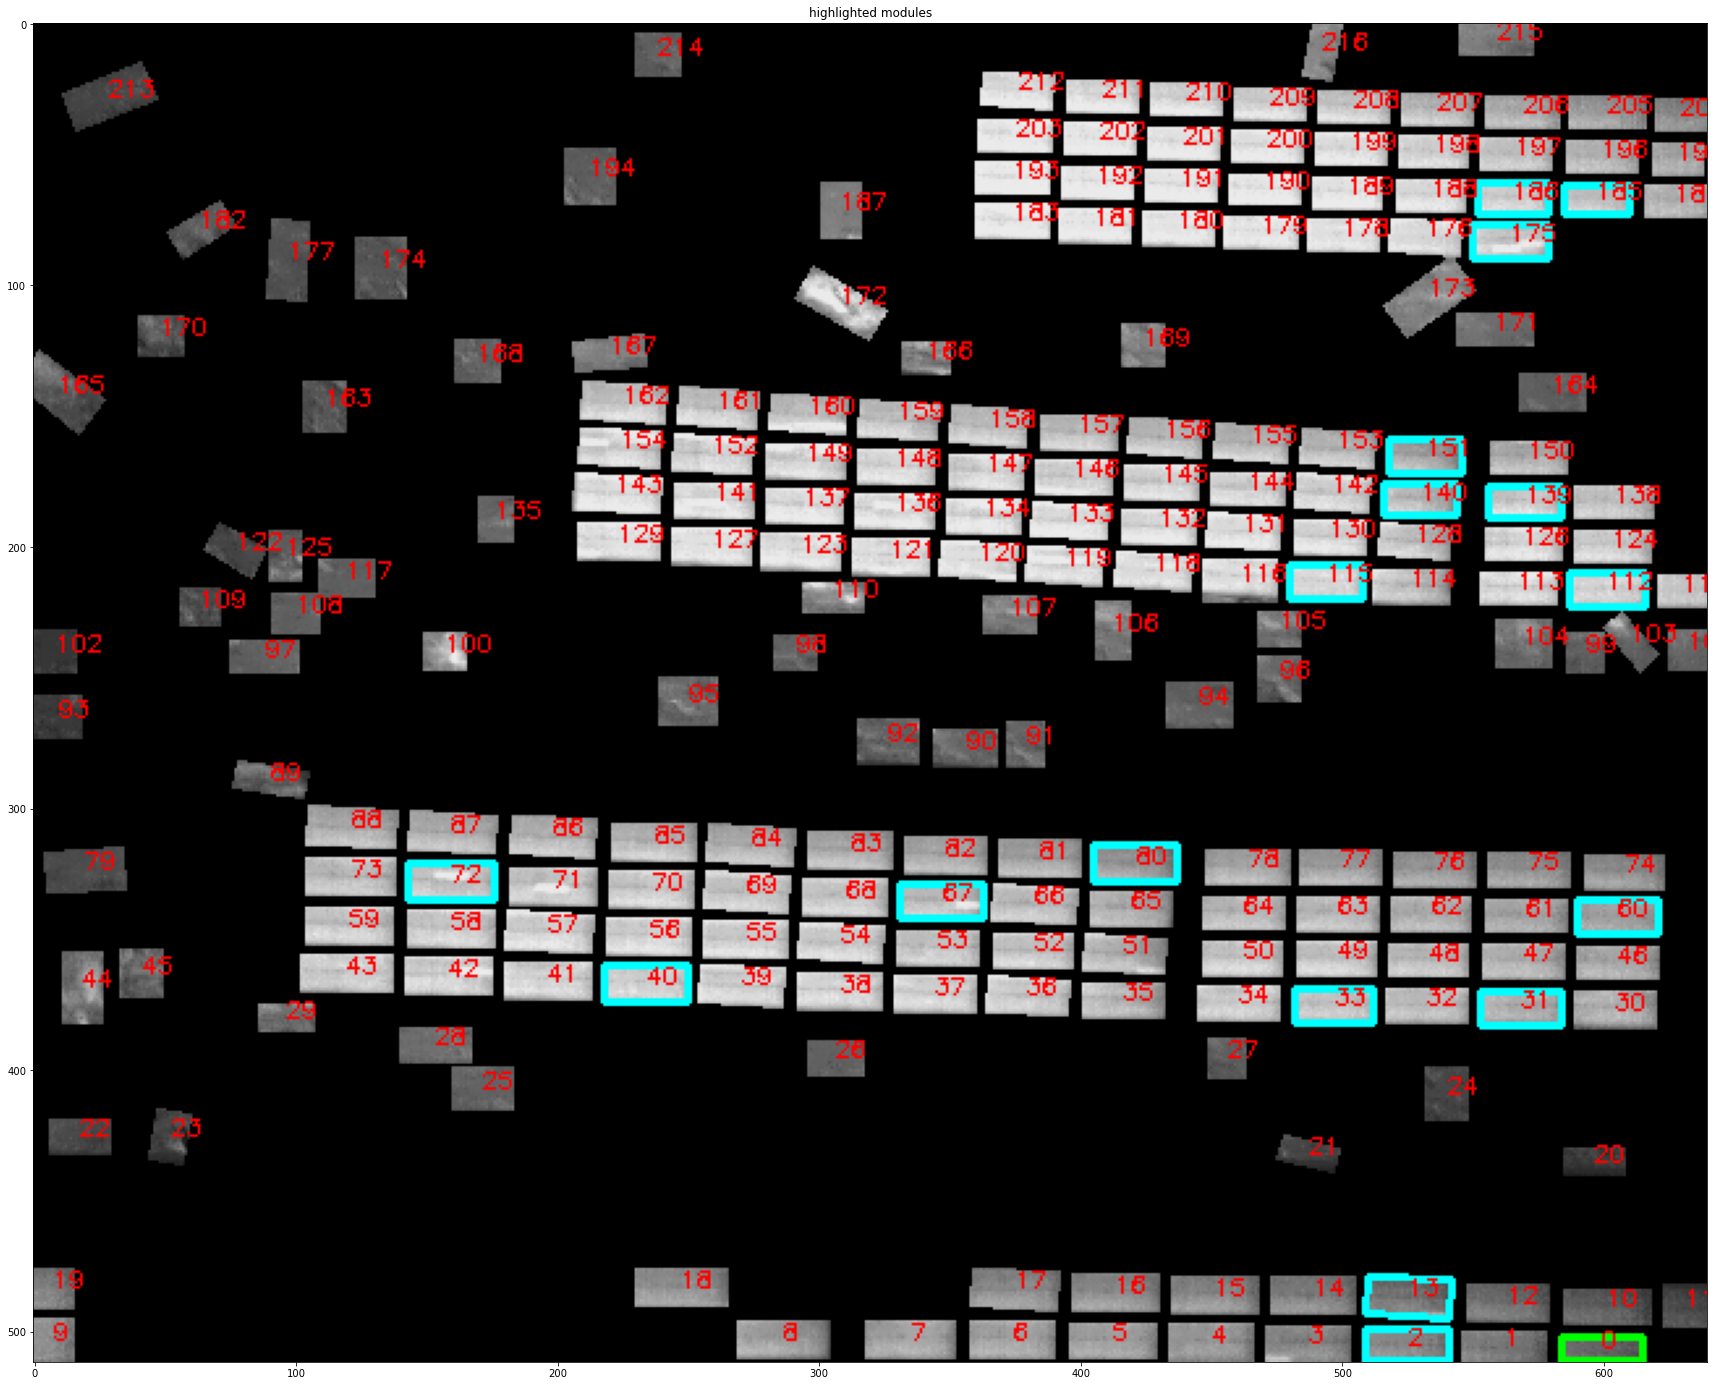

In [64]:
import copy
color_list = {
    "Single-Hotspot": (0,255,255), # aqua
    "Multi-Hotspots": (0,255,0), # green
    "Cluster-Anomaly": (255,255,0), # yellow
    "Module-Anomaly": (255,165,0), # orange
}
img_target_index = copy.deepcopy(img_mask_index)
for k, v in anomaly_contours.items():
    if k == "Normal":
        continue
    else:
        img_target_index = modules.get_img_target_contours(
            img_target_index, v, index=True, color=color_list[k])
module_extraction.show_img(
    {"highlighted modules":img_target_index}, cmap="gray", figsize=(30,30)
)

In [42]:
#string_anomaly_labels = modules.get_string_anomaly_labels(anomaly_contours["Module-Anomaly"])

In [43]:
img_string_index = modules.get_img_target_contours(
    modules.get_img_contours(img_org, index=False),
    anomaly_contours["Module-Anomaly"][string_anomaly_labels>=0], 
    index=True, color=(238,130,238)) # violet

KeyError: 'Module-Anomaly'

In [ ]:
module_extraction.show_img({"string-anomaly modules":img_string_index},cmap="gray",figsize=(30,30))

In [ ]:
#ToDo
## 異常部分へのマーキング（赤で囲む）
## 分類モデルの改良
## log transform for input temperature
## scaled の画像データを表示